Peak (A): 115.41768918419793
Center (x0, y0): (1019.6070749900131, 571.6749658053918)
Width (σx, σy): (714.6877243961623 µm, 777.6522080967559 µm)


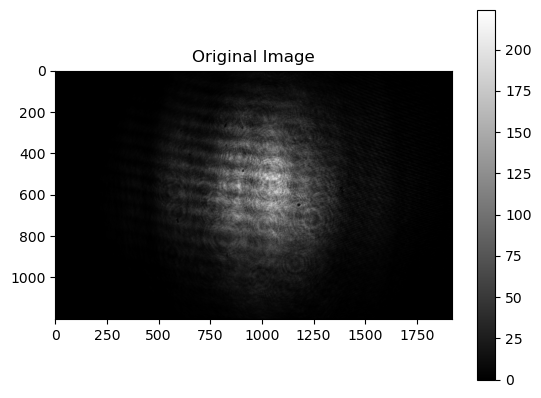

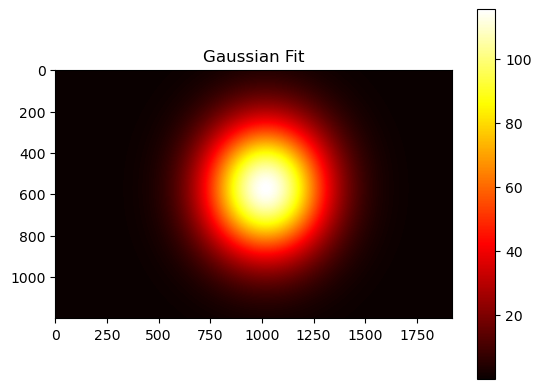

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('Image__2024-11-08__19-23-09_38cm.tiff')

# Define the 2D Gaussian function (unpack x and y from the tuple)
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y):
    x, y = coords  # Unpack the (x, y) tuple
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2)) - ((y - y0)**2 / (2 * sigma_y**2)))

# Create a meshgrid for x and y coordinates
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
x, y = np.meshgrid(x, y)

# Flatten the image and the meshgrid for curve fitting
data = image.flatten()
x = x.flatten()
y = y.flatten()

# Initial guess for the parameters: amplitude, center, and sigma
initial_guess = (np.max(image), image.shape[1] // 2, image.shape[0] // 2, 1, 1)

# Fit the Gaussian to the data
params, covariance = curve_fit(gaussian_2d, (x, y), data, p0=initial_guess)

# Extract the fitted parameters
A, x0, y0, sigma_x, sigma_y = params

# Calculate the width in micrometers (since each pixel corresponds to 3.45 µm)
sigma_x_um = sigma_x * 3.45  # in µm
sigma_y_um = sigma_y * 3.45  # in µm

# Print the results
print(f"Peak (A): {A}")
print(f"Center (x0, y0): ({x0}, {y0})")
print(f"Width (σx, σy): ({sigma_x_um} µm, {sigma_y_um} µm)")

# Plot the fitted Gaussian
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Original Image')

# Optionally, plot the Gaussian fit as a surface
fitted_image = gaussian_2d((x, y), *params).reshape(image.shape)
plt.figure()
plt.imshow(fitted_image, cmap='hot')
plt.colorbar()
plt.title('Gaussian Fit')

plt.show()


Image dimensions: 1920 pixels (x-direction), 1200 pixels (y-direction)
X-direction (row) width (1/e²): 2.46 mm
Y-direction (column) width (1/e²): 3.01 mm
Column with highest intensity for x-direction: 1054
Row with highest intensity for y-direction: 518


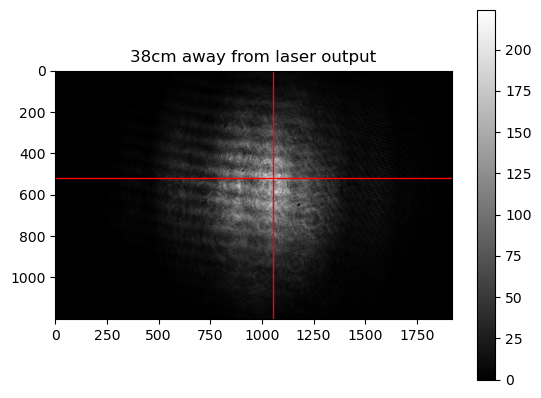

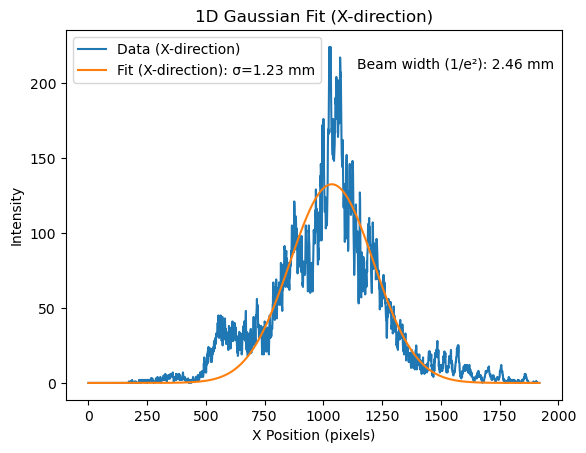

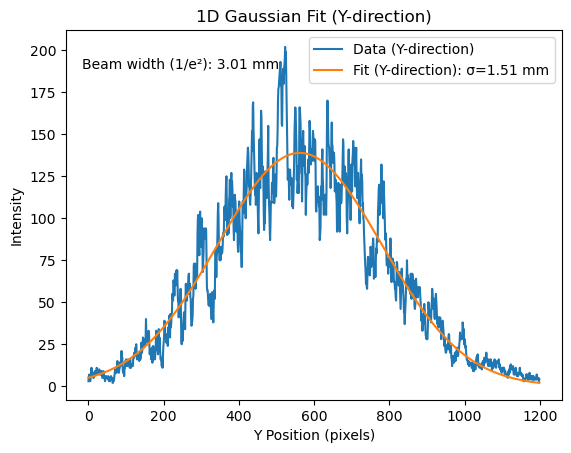

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('Image__2024-11-08__19-23-09_38cm.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2*(x - x0)**2 / (sigma**2))

# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*3.45/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*3.45/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('38cm away from laser output')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit


# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.58, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()


Image dimensions: 1920 pixels (x-direction), 1200 pixels (y-direction)
X-direction (row) width (1/e²): 2.97 mm
Y-direction (column) width (1/e²): 3.03 mm
Column with highest intensity for x-direction: 1026
Row with highest intensity for y-direction: 536


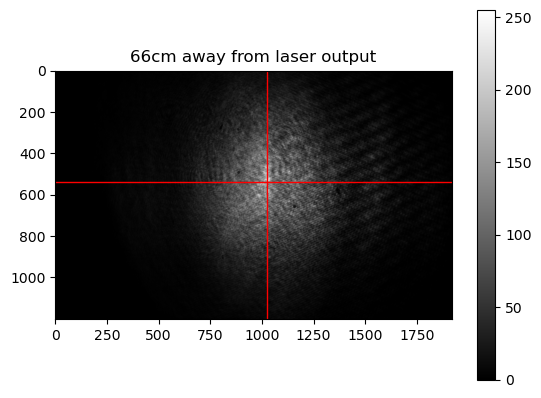

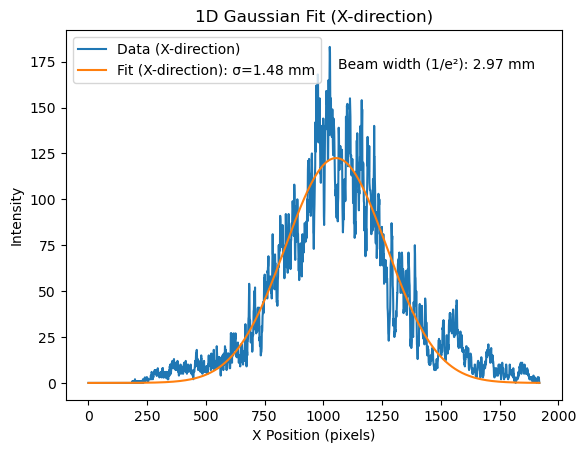

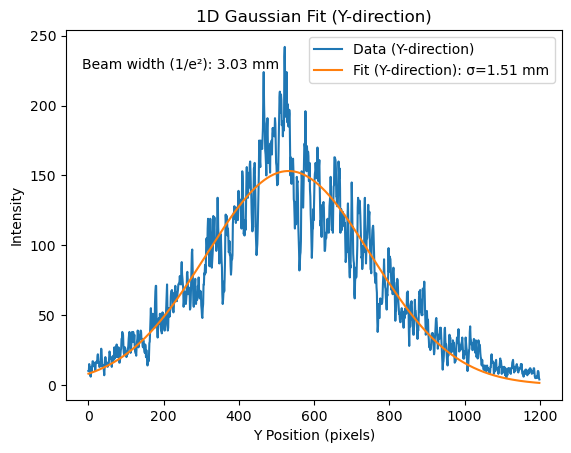

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('Image__2024-11-08__16-58-23.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2*(x - x0)**2 / (sigma**2))

# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*3.45/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*3.45/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('66cm away from laser output')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit

# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.55, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()


Image dimensions: 1920 pixels (x-direction), 1200 pixels (y-direction)
X-direction (row) width (1/e²): 2.01 mm
Y-direction (column) width (1/e²): 1.98 mm
Column with highest intensity for x-direction: 941
Row with highest intensity for y-direction: 593


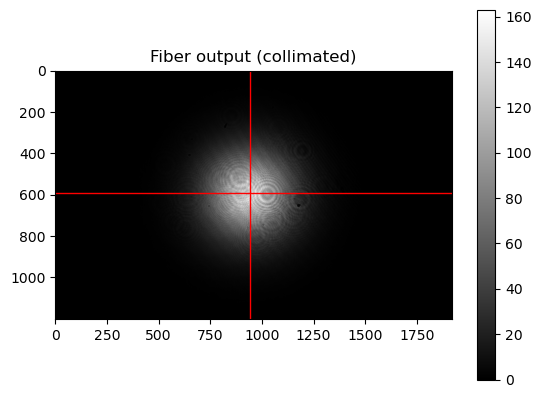

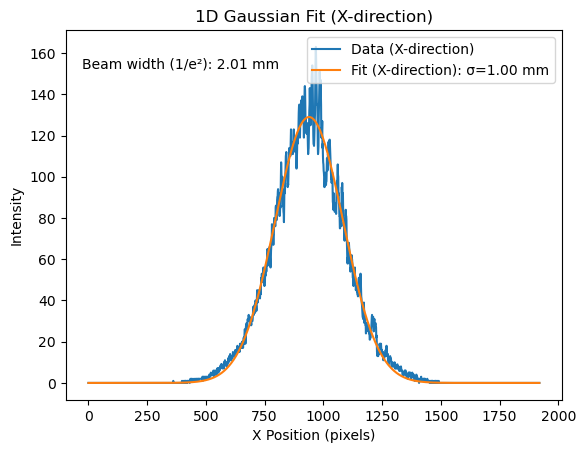

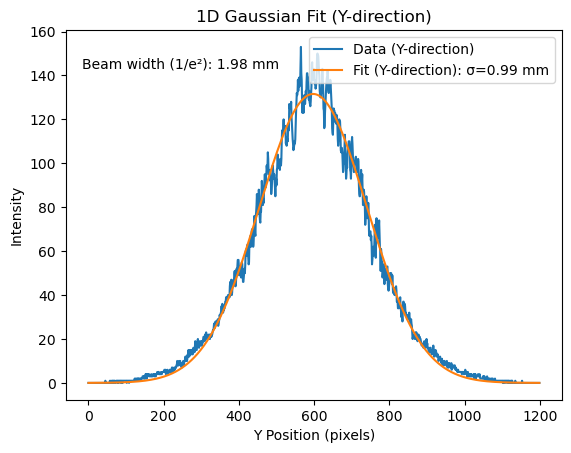

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('Image__2024-11-08__16-50-52.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2*(x - x0)**2 / (sigma**2))

# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*3.45/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*3.45/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Fiber output (collimated)')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit
# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()


Image dimensions: 1920 pixels (x-direction), 1200 pixels (y-direction)
X-direction (row) width (1/e²): 2.01 mm
Y-direction (column) width (1/e²): 0.59 mm
Column with highest intensity for x-direction: 870
Row with highest intensity for y-direction: 605


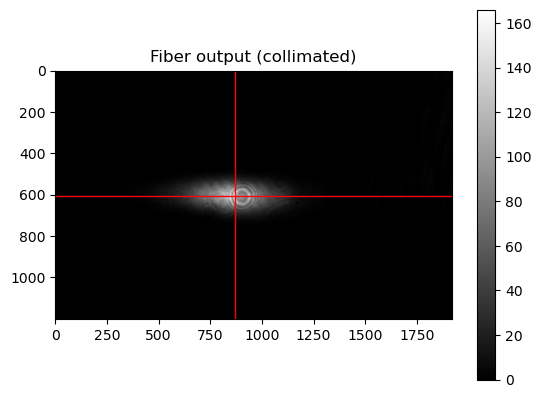

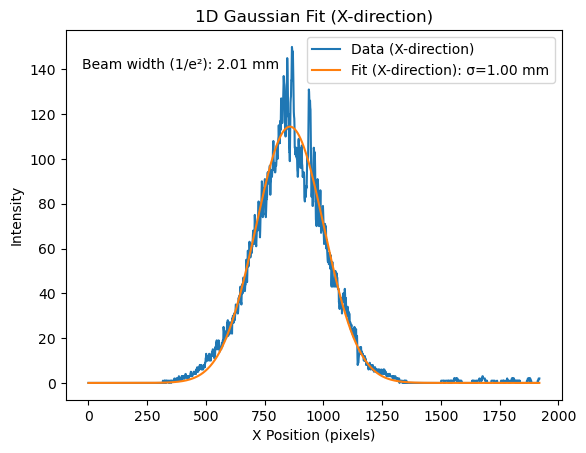

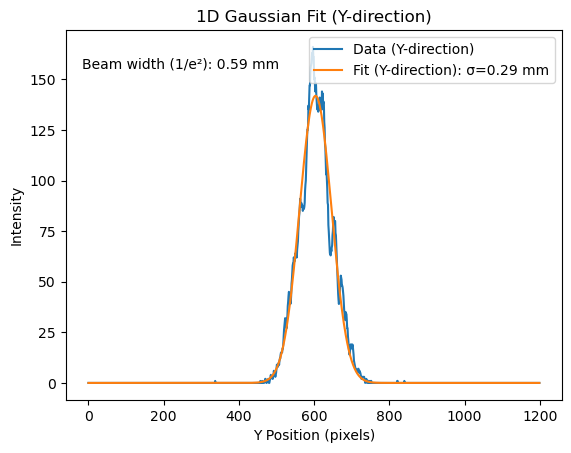

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('Image__2024-11-11__12-37-44_3dmot.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2*(x - x0)**2 / (sigma**2))

# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*3.45/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*3.45/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Fiber output (collimated)')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit
# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()



Fitted linear equation: NAe2 = -0.000027 * Wavelength + 0.074917
Predicted NAe2 at 461 nm: 0.062592


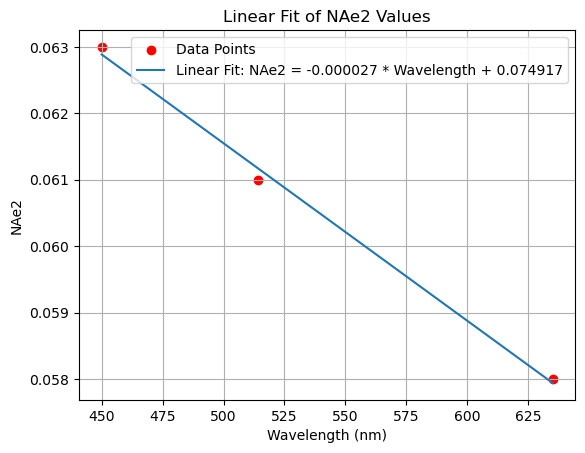

In [102]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Given data points (wavelength, NAe2 values)
wavelengths = np.array([450, 514, 635])  # Wavelengths in nm
NAe2_values = np.array([0.063, 0.061, 0.058])  # Corresponding NAe2 values

# Define a linear model for fitting
def linear_model(x, a, b):
    return a * x + b

# Fit the data to the linear model
params, covariance = curve_fit(linear_model, wavelengths, NAe2_values)

# Extract the fitted parameters (slope and intercept)
a, b = params
print(f"Fitted linear equation: NAe2 = {a:.6f} * Wavelength + {b:.6f}")

# Predict the NAe2 value for 461 nm
predicted_NAe2 = linear_model(461, a, b)
print(f"Predicted NAe2 at 461 nm: {predicted_NAe2:.6f}")

# Plot the data points and the fitted curve
plt.scatter(wavelengths, NAe2_values, color='red', label='Data Points')
x_vals = np.linspace(min(wavelengths), max(wavelengths), 100)
y_vals = linear_model(x_vals, a, b)
plt.plot(x_vals, y_vals, label=f'Linear Fit: NAe2 = {a:.6f} * Wavelength + {b:.6f}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('NAe2')
plt.title('Linear Fit of NAe2 Values')
plt.legend()
plt.grid(True)
plt.show()



Fitted polynomial equation: NAe2 = 0.000000 * Wavelength^2 + -0.000065 * Wavelength + 0.085135
Predicted NAe2 at 461 nm: 0.062636


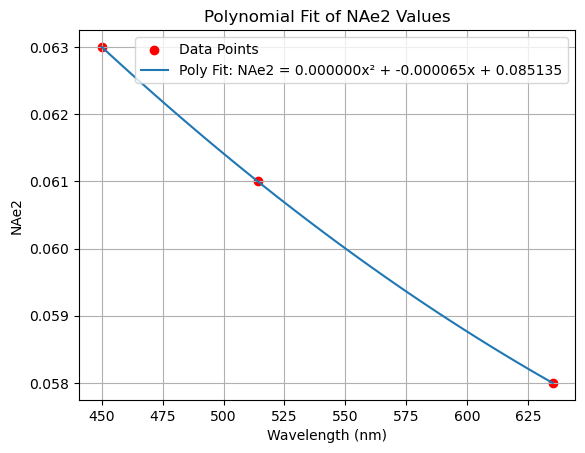

In [103]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Given data points (wavelength, NAe2 values)
wavelengths = np.array([450, 514, 635])  # Wavelengths in nm
NAe2_values = np.array([0.063, 0.061, 0.058])  # Corresponding NAe2 values

# Define a polynomial model (2nd degree) for fitting
def poly_model(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the data to the polynomial model
params, covariance = curve_fit(poly_model, wavelengths, NAe2_values)

# Extract the fitted parameters (a, b, c)
a, b, c = params
print(f"Fitted polynomial equation: NAe2 = {a:.6f} * Wavelength^2 + {b:.6f} * Wavelength + {c:.6f}")

# Predict the NAe2 value for 461 nm using the polynomial model
predicted_NAe2 = poly_model(461, a, b, c)
print(f"Predicted NAe2 at 461 nm: {predicted_NAe2:.6f}")

# Plot the data points and the fitted polynomial curve
plt.scatter(wavelengths, NAe2_values, color='red', label='Data Points')
x_vals = np.linspace(min(wavelengths), max(wavelengths), 100)
y_vals = poly_model(x_vals, *params)
plt.plot(x_vals, y_vals, label=f'Poly Fit: NAe2 = {a:.6f}x² + {b:.6f}x + {c:.6f}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('NAe2')
plt.title('Polynomial Fit of NAe2 Values')
plt.legend()
plt.grid(True)
plt.show()


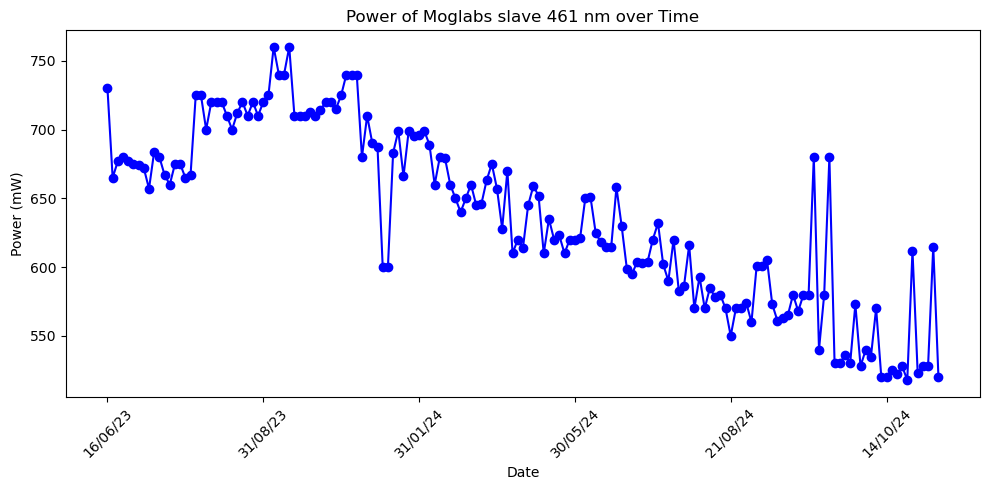

In [10]:
data = [
    ["16/06/23", 730],
    ["19/06/23", 665],
    ["20/06/23", None],
    ["21/06/23", 677],
    ["22/06/23", 680],
    ["23/06/23", 677],
    ["26/06/23", 675],
    ["27/06/23", 674],
    ["28/06/23", 672],
    ["29/06/23", 657],
    ["30/06/23", 684],
    ["03/07/23", 680],
    ["04/07/23", 667],
    ["05/07/23", 660],
    ["06/07/23", None],
    ["07/07/23", 675],
    ["10/07/23", 675],
    ["11/07/23", 665],
    ["13/07/23", None],
    ["20/07/23", 667],
    ["24/07/23", None],
    ["25/07/23", 725],
    ["26/07/23", 725],
    ["27/07/23", 700],
    ["28/07/23", 720],
    ["31/07/23", 720],
    ["03/08/23", 720],
    ["04/08/23", 710],
    ["21/08/23", 700],
    ["22/08/23", None],
    ["23/08/23", None],
    ["24/08/23", 712],
    ["25/08/23", 720],
    ["28/08/23", 710],
    ["29/08/23", 720],
    ["30/08/23", 710],
    ["31/08/23", 720],
    ["01/09/23", 725],
    ["02/09/23", 760],
    ["03/09/23", None],
    ["04/09/23", None],
    ["05/09/23", None],
    ["06/09/23", None],
    ["07/09/23", None],
    ["08/09/23", 740],
    ["09/09/23", None],
    ["10/09/23", None],
    ["11/09/23", 740],
    ["12/09/23", 760],
    ["13/09/23", 710],
    ["14/09/23", 710],
    ["15/09/23", 710],
    ["18/09/23", 713],
    ["19/09/23", 710],
    ["20/09/23", 714],
    ["21/09/23", 720],
    ["22/09/23", 720],
    ["25/09/23", 715],
    ["26/09/23", None],
    ["27/09/23", None],
    ["28/09/23", 725],
    ["29/09/23", None],
    ["03/10/23", None],
    ["05/10/23", None],
    ["06/10/23", 740],
    ["11/10/23", None],
    ["13/10/23", None],
    ["16/10/23", None],
    ["18/10/23", 740],
    ["19/10/23", None],
    ["20/10/23", None],
    ["23/10/23", 740],
    ["24/10/23", None],
    ["25/10/23", None],
    ["26/10/23", None],
    ["31/10/23", None],
    ["05/12/23", 680],
    ["06/12/23", 710],
    ["07/12/23", 690],
    ["11/12/23", None],
    ["12/12/23", None],
    ["18/12/23", None],
    ["22/12/23", 687],
    ["02/01/24", None],
    ["03/01/24", None],
    ["04/01/24", None],
    ["05/01/24", None],
    ["15/01/24", None],
    ["16/01/24", None],
    ["17/01/24", None],
    ["18/01/24", None],
    ["19/01/24", None],
    ["22/01/24", 600],
    ["23/01/24", 600],
    ["24/01/24", 683],
    ["25/01/24", 699],
    ["26/01/24", 666],
    ["29/01/24", 699],
    ["30/01/24", 695],
    ["31/01/24", 696],
    ["01/02/24", 699],
    ["05/02/24", 689],
    ["06/02/24", None],
    ["07/02/24", None],
    ["08/02/24", None],
    ["09/02/24", 660],
    ["12/02/24", 680],
    ["14/02/24", 679],
    ["21/02/24", None],
    ["22/02/24", None],
    ["23/02/24", None],
    ["23/02/24", None],
    ["05/03/24", None],
    ["06/03/24", None],
    ["07/03/24", 660],
    ["08/03/24", 650],
    ["11/03/24", 640],
    ["12/03/24", 650],
    ["13/03/24", 660],
    ["14/03/24", 645],
    ["19/03/24", 646],
    ["20/03/24", None],
    ["21/03/24", None],
    ["22/03/24", None],
    ["25/03/24", 663],
    ["26/03/24", 675],
    ["02/04/24", 657],
    ["08/04/24", None],
    ["09/04/24", None],
    ["11/04/24", None],
    ["17/04/24", None],
    ["18/04/24", None],
    ["23/04/24", None],
    ["02/05/24", None],
    ["03/05/24", None],
    ["08/05/24", 628],
    ["09/05/24", 670],
    ["10/05/24", 610],
    ["13/05/24", 620],
    ["14/05/24", 614],
    ["15/05/24", 645],
    ["16/05/24", 659],
    ["20/05/24", 652],
    ["21/05/24", 610],
    ["22/05/24", 635],
    ["23/05/24", 620],
    ["27/05/24", 623],
    ["28/05/24", 610],
    ["29/05/24", 620],
    ["30/05/24", 620],
    ["31/05/24", 621],
    ["03/06/24", 650],
    ["04/06/24", 651],
    ["06/06/24", 625],
    ["07/06/24", 618],
    ["10/06/24", 615],
    ["11/06/24", 615],
    ["12/06/24", 658],
    ["17/06/24", 630],
    ["18/06/24", None],
    ["19/06/24", 599],
    ["20/06/24", None],
    ["21/06/24", 595],
    ["25/06/24", 604],
    ["26/06/24", 603],
    ["27/06/24", 604],
    ["28/06/24", 620],
    ["01/07/24", 632],
    ["02/07/24", 602],
    ["03/07/24", 590],
    ["09/07/24", 620],
    ["22/07/24", 583],
    ["23/07/24", 586],
    ["24/07/24", 616],
    ["25/07/24", 570],
    ["26/07/24", 593],
    ["29/07/24", 570],
    ["30/07/24", None],
    ["31/07/24", 585],
    ["01/08/24", 578],
    ["05/08/24", 580],
    ["06/08/24", 570],
    ["21/08/24", 550],
    ["22/08/24", 570],
    ["23/08/24", 570],
    ["26/08/24", 574],
    ["27/08/24", 560],
    ["28/08/24", 601],
    ["29/08/24", 601],
    ["02/09/24", 605],
    ["09/09/24", 573],
    ["11/09/24", 561],
    ["12/09/24", 563],
    ["16/09/24", 565],
    ["17/09/24", 580],
    ["19/09/24", 568],
    ["20/09/24", 580],
    ["23/09/24", 580],
    ["24/09/24", 680],
    ["25/09/24", 540],
    ["26/09/24", 580],
    ["28/09/24", 680],
    ["30/09/24", 530],
    ["01/10/24", 530],
    ["03/10/24", 536],
    ["04/10/24", 530],
    ["06/10/24", 573],
    ["07/10/24", 528],
    ["08/10/24", 540],
    ["09/10/24", 535],
    ["10/10/24", 570],
    ["11/10/24", 520],
    ["14/10/24", 520],
    ["15/10/24", 525],
    ["16/10/24", 522],
    ["17/10/24", 528],
    ["23/10/24", 518],
    ["24/10/24", 612],
    ["25/10/24", 523],
    ["28/10/24", 528],
    ["04/11/24", 528],
    ["05/11/24", 615],
    ["06/11/24", 520]
]

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Remove rows with None values
filtered_data = [row for row in data if row[1] is not None]

# Extract x and y values for plotting
dates = [row[0] for row in filtered_data]
powers = [row[1] for row in filtered_data]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(dates, powers, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Power (mW)')
plt.title('Power of Moglabs slave 461 nm over Time')

# Limit the number of x-ticks
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))  # Set the number of ticks (6 in this case)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


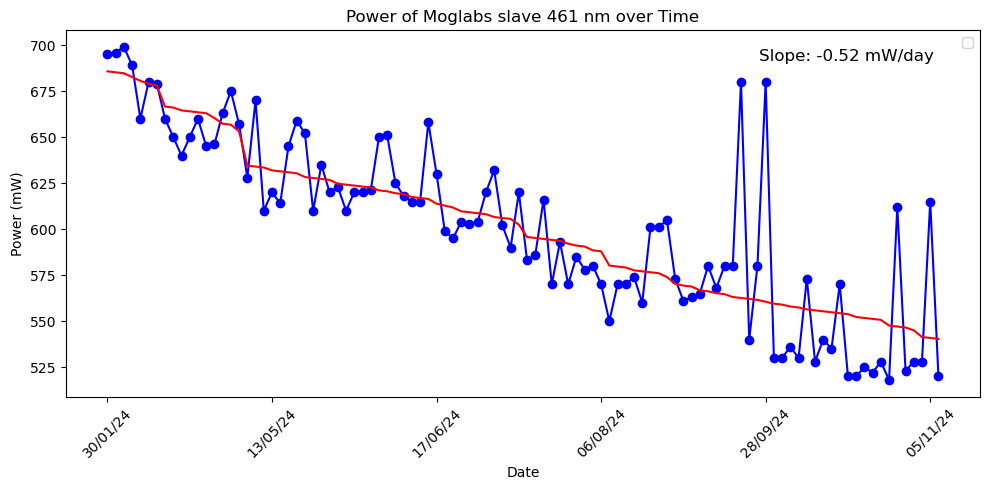

Linear fit slope (relation per day): -0.5175357384070921
Linear fit intercept: 685.7543572082027


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
data = [
    ["30/01/24", 695],
    ["31/01/24", 696],
    ["01/02/24", 699],
    ["05/02/24", 689],
    ["06/02/24", None],
    ["07/02/24", None],
    ["08/02/24", None],
    ["09/02/24", 660],
    ["12/02/24", 680],
    ["14/02/24", 679],
    ["21/02/24", None],
    ["22/02/24", None],
    ["23/02/24", None],
    ["23/02/24", None],
    ["05/03/24", None],
    ["06/03/24", None],
    ["07/03/24", 660],
    ["08/03/24", 650],
    ["11/03/24", 640],
    ["12/03/24", 650],
    ["13/03/24", 660],
    ["14/03/24", 645],
    ["19/03/24", 646],
    ["20/03/24", None],
    ["21/03/24", None],
    ["22/03/24", None],
    ["25/03/24", 663],
    ["26/03/24", 675],
    ["02/04/24", 657],
    ["08/04/24", None],
    ["09/04/24", None],
    ["11/04/24", None],
    ["17/04/24", None],
    ["18/04/24", None],
    ["23/04/24", None],
    ["02/05/24", None],
    ["03/05/24", None],
    ["08/05/24", 628],
    ["09/05/24", 670],
    ["10/05/24", 610],
    ["13/05/24", 620],
    ["14/05/24", 614],
    ["15/05/24", 645],
    ["16/05/24", 659],
    ["20/05/24", 652],
    ["21/05/24", 610],
    ["22/05/24", 635],
    ["23/05/24", 620],
    ["27/05/24", 623],
    ["28/05/24", 610],
    ["29/05/24", 620],
    ["30/05/24", 620],
    ["31/05/24", 621],
    ["03/06/24", 650],
    ["04/06/24", 651],
    ["06/06/24", 625],
    ["07/06/24", 618],
    ["10/06/24", 615],
    ["11/06/24", 615],
    ["12/06/24", 658],
    ["17/06/24", 630],
    ["18/06/24", None],
    ["19/06/24", 599],
    ["20/06/24", None],
    ["21/06/24", 595],
    ["25/06/24", 604],
    ["26/06/24", 603],
    ["27/06/24", 604],
    ["28/06/24", 620],
    ["01/07/24", 632],
    ["02/07/24", 602],
    ["03/07/24", 590],
    ["09/07/24", 620],
    ["22/07/24", 583],
    ["23/07/24", 586],
    ["24/07/24", 616],
    ["25/07/24", 570],
    ["26/07/24", 593],
    ["29/07/24", 570],
    ["30/07/24", None],
    ["31/07/24", 585],
    ["01/08/24", 578],
    ["05/08/24", 580],
    ["06/08/24", 570],
    ["21/08/24", 550],
    ["22/08/24", 570],
    ["23/08/24", 570],
    ["26/08/24", 574],
    ["27/08/24", 560],
    ["28/08/24", 601],
    ["29/08/24", 601],
    ["02/09/24", 605],
    ["09/09/24", 573],
    ["11/09/24", 561],
    ["12/09/24", 563],
    ["16/09/24", 565],
    ["17/09/24", 580],
    ["19/09/24", 568],
    ["20/09/24", 580],
    ["23/09/24", 580],
    ["24/09/24", 680],
    ["25/09/24", 540],
    ["26/09/24", 580],
    ["28/09/24", 680],
    ["30/09/24", 530],
    ["01/10/24", 530],
    ["03/10/24", 536],
    ["04/10/24", 530],
    ["06/10/24", 573],
    ["07/10/24", 528],
    ["08/10/24", 540],
    ["09/10/24", 535],
    ["10/10/24", 570],
    ["11/10/24", 520],
    ["14/10/24", 520],
    ["15/10/24", 525],
    ["16/10/24", 522],
    ["17/10/24", 528],
    ["23/10/24", 518],
    ["24/10/24", 612],
    ["25/10/24", 523],
    ["28/10/24", 528],
    ["04/11/24", 528],
    ["05/11/24", 615],
    ["06/11/24", 520]
]

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime

# Sample data format: [["Date", Power], ...]
# Ensure your 'data' variable is already in the format [["Date", Power], ...]

# Remove rows with None values
filtered_data = [row for row in data if row[1] is not None]

# Extract x (dates) and y (powers) values for plotting
dates = [row[0] for row in filtered_data]
powers = [row[1] for row in filtered_data]

# Convert the dates to numerical values (days since the first date) for the linear fit
date_objs = [datetime.strptime(date, "%d/%m/%y") for date in dates]
days_since_start = [(date - date_objs[0]).days for date in date_objs]

# Calculate the linear fit (manually)
n = len(days_since_start)
x_sum = sum(days_since_start)
y_sum = sum(powers)
xy_sum = sum([x * y for x, y in zip(days_since_start, powers)])
x_squared_sum = sum([x**2 for x in days_since_start])

# Calculate the slope (m) and intercept (b)
slope = (n * xy_sum - x_sum * y_sum) / (n * x_squared_sum - x_sum**2)
intercept = (y_sum - slope * x_sum) / n

# Create the linear fit line
fit_line = [slope * day + intercept for day in days_since_start]

# Plotting the data and linear fit
plt.figure(figsize=(10, 5))
plt.plot(dates, powers, marker='o', linestyle='-', color='b')
plt.plot(dates, fit_line, color='r')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Power (mW)')
plt.title('Power of Moglabs slave 461 nm over Time')

# Limit the number of x-ticks
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))  # Set the number of ticks (6 in this case)

# Add the slope text to the plot
plt.text(0.95, 0.95, f"Slope: {slope:.2f} mW/day", transform=plt.gca().transAxes, ha='right', va='top', fontsize=12, color='black')

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

# Print the linear fit parameters
print(f"Linear fit slope (relation per day): {slope}")
print(f"Linear fit intercept: {intercept}")


Image dimensions: 4024 pixels (x-direction), 3036 pixels (y-direction)
X-direction (row) width (1/e²): 0.01 mm
Y-direction (column) width (1/e²): 0.01 mm
Column with highest intensity for x-direction: 1431
Row with highest intensity for y-direction: 887


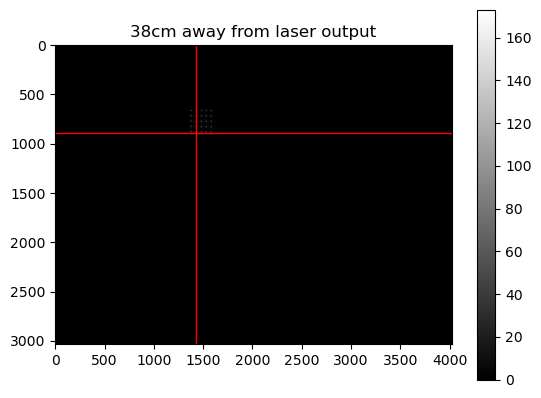

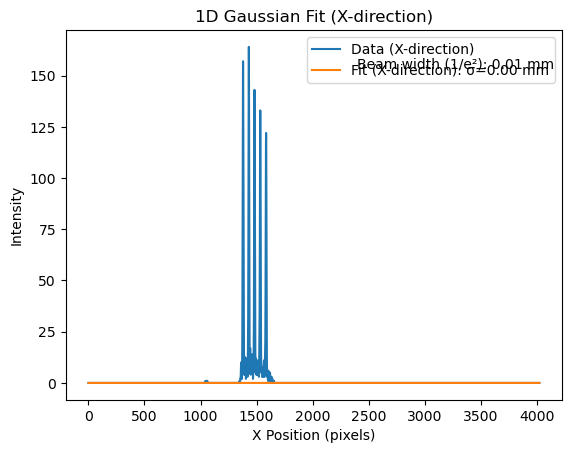

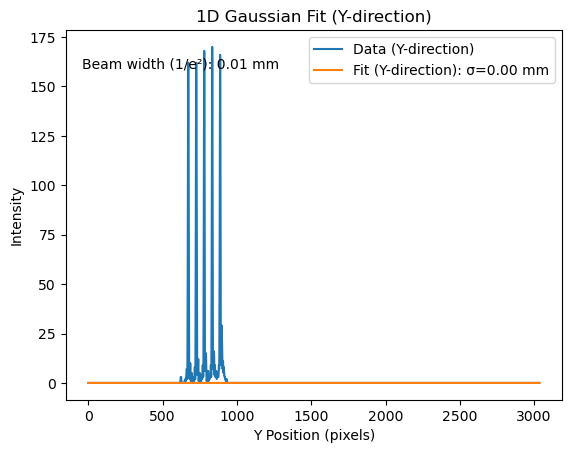

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('balanced98.985.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")



# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*3.45/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*3.45/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('38cm away from laser output')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit


# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.58, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()


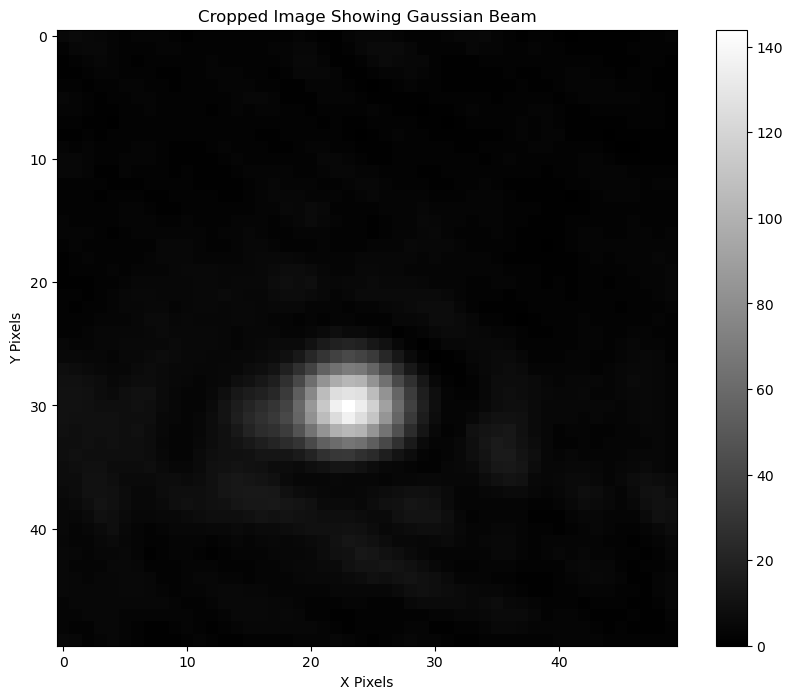

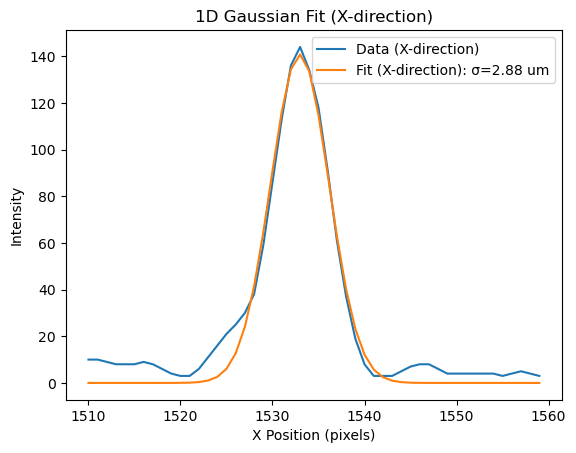

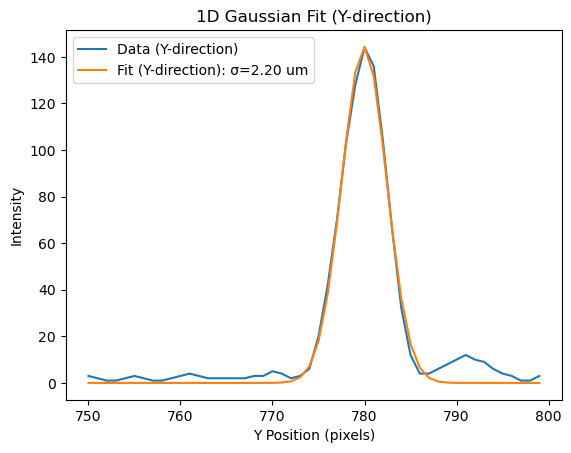

X-direction beam waist (1/e²): 2.88 um
Y-direction beam wasit (1/e²): 2.20 um


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('balanced98.985.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 750, 800  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 1510, 1560  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Define the cropped x and y ranges
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Cropped Image Showing Gaussian Beam')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Extract row and column intensity profiles for fitting
# Use the row with the maximum intensity for x-direction fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]

# Use the column with the maximum intensity for y-direction fitting
column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped), 10]
)
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped), 10]
)
A_y, y0_y, sigma_y_fit = popt_y

# Incorporate magnification in the conversion from pixels to mm
pixel_to_mm = 1.85 * (24.5 / 100)  # Adjust scaling factor with magnification
sigma_x_fit_mm = sigma_x_fit * pixel_to_mm
sigma_y_fit_mm = sigma_y_fit * pixel_to_mm

# Plot the 1D Gaussian fit for the x-direction
plt.figure()
plt.plot(x_cropped, max_intensity_row_cropped, label='Data (X-direction)')
plt.plot(x_cropped, gaussian_1d(x_cropped, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit_mm:.2f} um')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()
plt.show()

# Plot the 1D Gaussian fit for the y-direction
plt.figure()
plt.plot(y_cropped, max_intensity_column_cropped, label='Data (Y-direction)')
plt.plot(y_cropped, gaussian_1d(y_cropped, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit_mm:.2f} um')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.show()

# Print the results
print(f"X-direction beam waist (1/e²): {sigma_x_fit_mm:.2f} um")
print(f"Y-direction beam wasit (1/e²): {sigma_y_fit_mm:.2f} um")


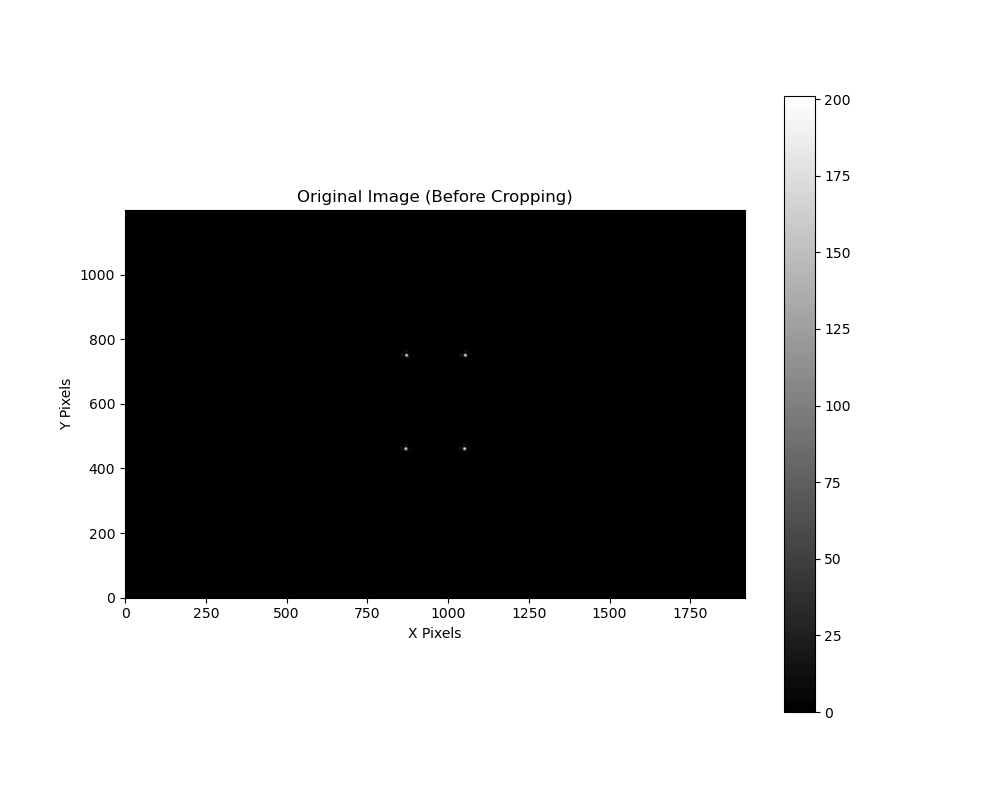

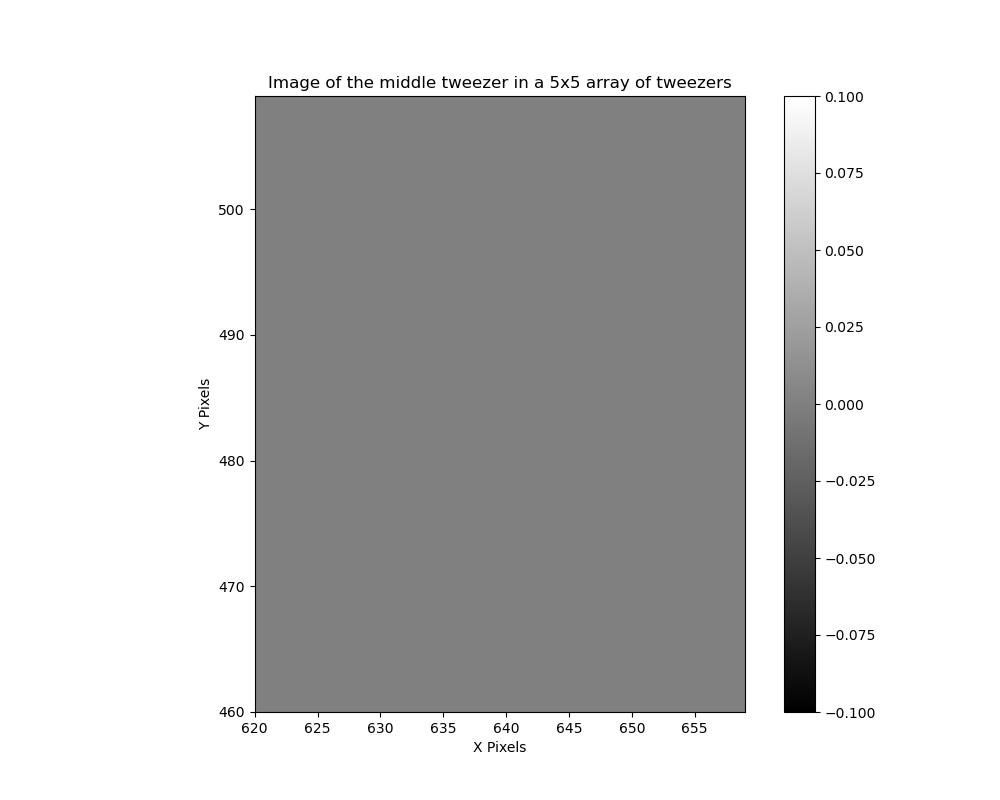

In [4]:
%matplotlib widget

# Load your .tiff image
image = io.imread('4_spots_square.tiff')


# Plot the original (uncropped) image
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Original Image (Before Cropping)')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 510  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x = np.arange(roi_x_start, roi_x_end)
y = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x, y)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x[0], x[-1], y[0], y[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()






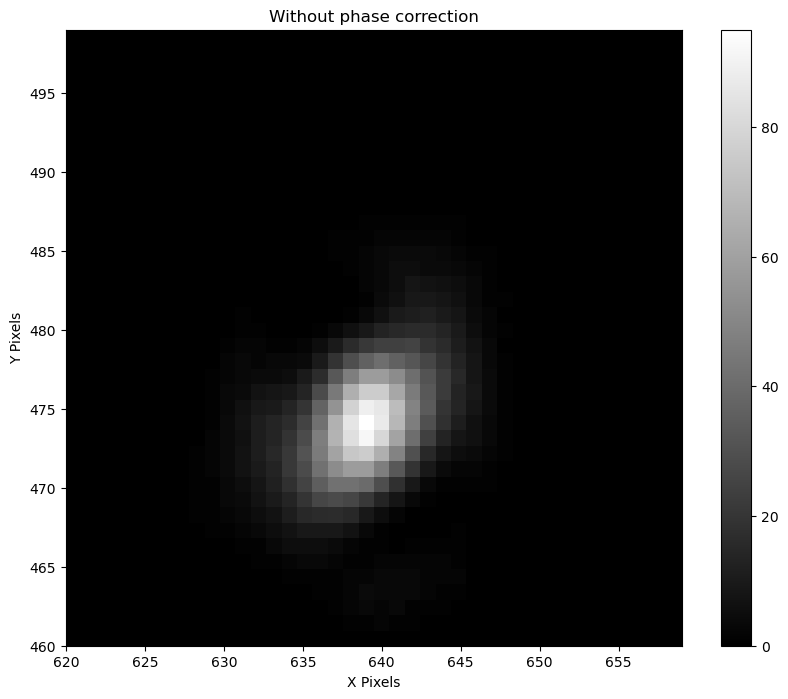

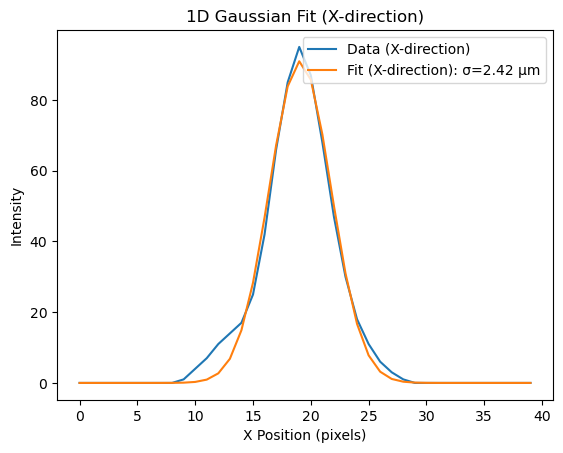

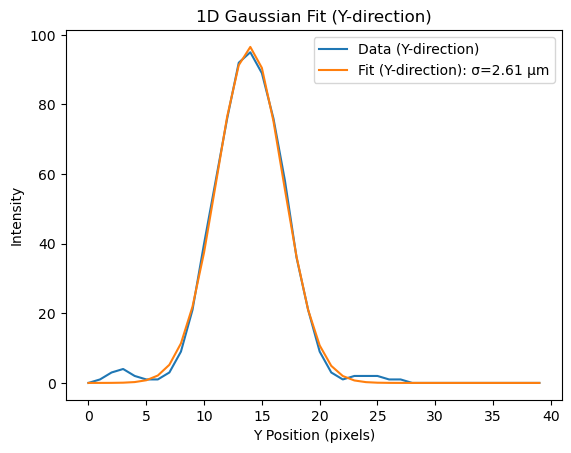

X-direction beam waist (1/e²): 2.42 μm
Y-direction beam waist (1/e²): 2.61 μm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('no_correction.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Without phase correction')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Extract row and column intensity profiles for fitting
# Use the row with the maximum intensity for x-direction fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

# Use the column with the maximum intensity for y-direction fitting
column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)
A_y, y0_y, sigma_y_fit = popt_y

# Incorporate magnification in the conversion from pixels to mm
pixel_to_mm = 1.85 * (24.5 / 100)  # Adjust scaling factor with magnification
sigma_x_fit_mm = sigma_x_fit * pixel_to_mm
sigma_y_fit_mm = sigma_y_fit * pixel_to_mm

# Plot the 1D Gaussian fit for the x-direction
plt.figure()
plt.plot(x_cropped_row, max_intensity_row_cropped, label='Data (X-direction)')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit_mm:.2f} μm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()
plt.show()

# Plot the 1D Gaussian fit for the y-direction
plt.figure()
plt.plot(y_cropped_col, max_intensity_column_cropped, label='Data (Y-direction)')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit_mm:.2f} μm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.show()

# Print the results
print(f"X-direction beam waist (1/e²): {sigma_x_fit_mm:.2f} μm")
print(f"Y-direction beam waist (1/e²): {sigma_y_fit_mm:.2f} μm")


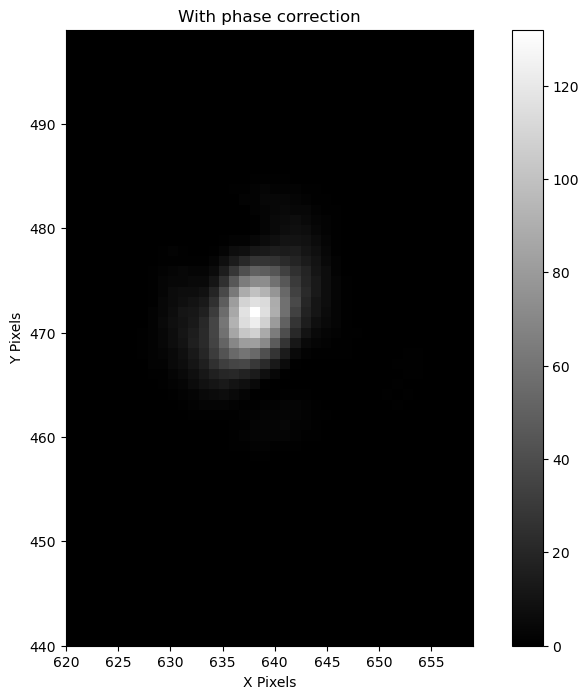

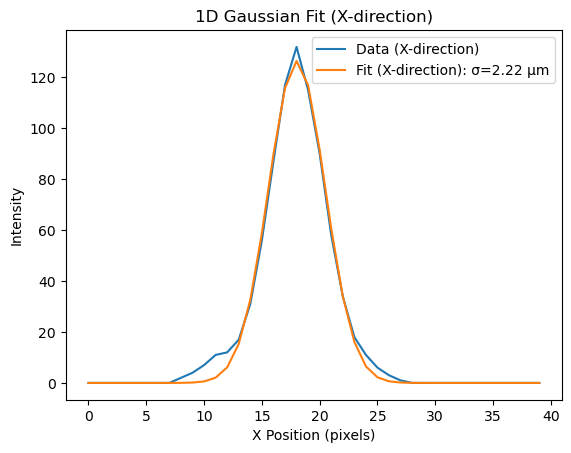

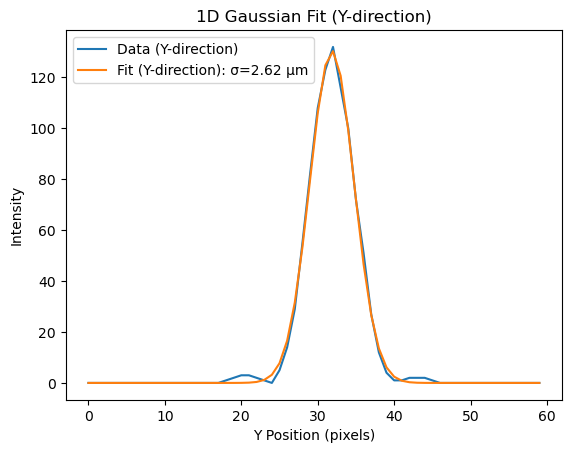

X-direction beam waist (1/e²): 2.22 μm
Y-direction beam waist (1/e²): 2.62 μm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('without_correction.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 440, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('With phase correction')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Extract row and column intensity profiles for fitting
# Use the row with the maximum intensity for x-direction fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

# Use the column with the maximum intensity for y-direction fitting
column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)
A_y, y0_y, sigma_y_fit = popt_y

# Incorporate magnification in the conversion from pixels to mm
pixel_to_mm = 1.85 * (24.5 / 100)  # Adjust scaling factor with magnification
sigma_x_fit_mm = sigma_x_fit * pixel_to_mm
sigma_y_fit_mm = sigma_y_fit * pixel_to_mm

# Plot the 1D Gaussian fit for the x-direction
plt.figure()
plt.plot(x_cropped_row, max_intensity_row_cropped, label='Data (X-direction)')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit_mm:.2f} μm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()
plt.show()

# Plot the 1D Gaussian fit for the y-direction
plt.figure()
plt.plot(y_cropped_col, max_intensity_column_cropped, label='Data (Y-direction)')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit_mm:.2f} μm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.show()

# Print the results
print(f"X-direction beam waist (1/e²): {sigma_x_fit_mm:.2f} μm")
print(f"Y-direction beam waist (1/e²): {sigma_y_fit_mm:.2f} μm")


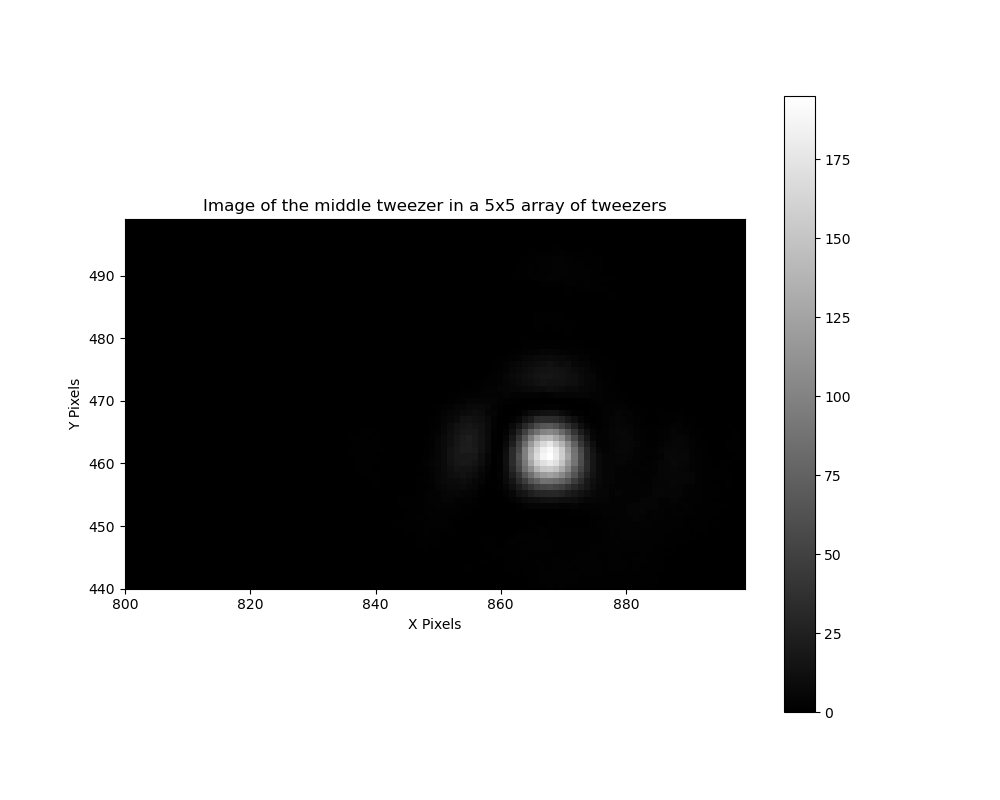

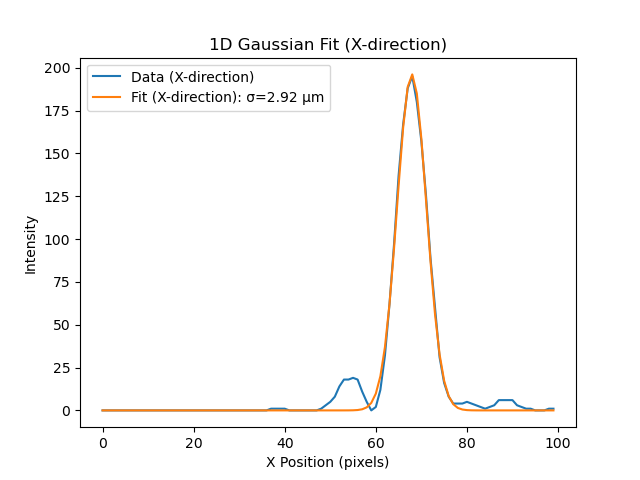

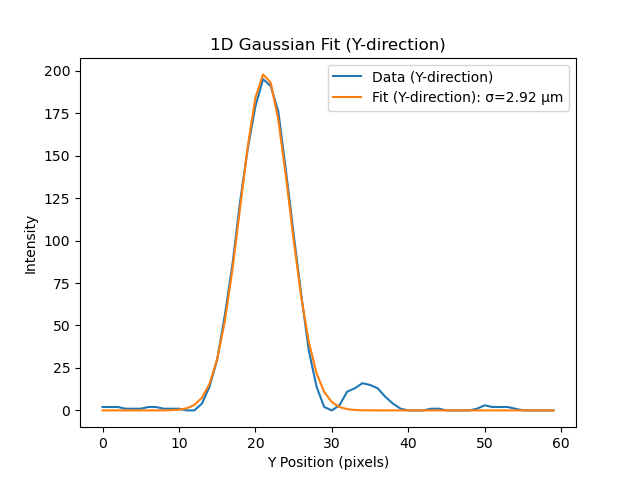

X-direction beam waist (1/e²): 2.92 μm
Y-direction beam waist (1/e²): 2.92 μm


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('4_spots_square.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 440, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 800, 900  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Extract row and column intensity profiles for fitting
# Use the row with the maximum intensity for x-direction fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

# Use the column with the maximum intensity for y-direction fitting
column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)
A_y, y0_y, sigma_y_fit = popt_y

# Incorporate magnification in the conversion from pixels to mm
pixel_to_mm = 1.85 * (24.5 / 100)  # Adjust scaling factor with magnification
sigma_x_fit_mm = sigma_x_fit * pixel_to_mm
sigma_y_fit_mm = sigma_y_fit * pixel_to_mm

# Plot the 1D Gaussian fit for the x-direction
plt.figure()
plt.plot(x_cropped_row, max_intensity_row_cropped, label='Data (X-direction)')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit_mm:.2f} μm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()
plt.show()

# Plot the 1D Gaussian fit for the y-direction
plt.figure()
plt.plot(y_cropped_col, max_intensity_column_cropped, label='Data (Y-direction)')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit_mm:.2f} μm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.show()

# Print the results
print(f"X-direction beam waist (1/e²): {sigma_x_fit_mm:.2f} μm")
print(f"Y-direction beam waist (1/e²): {sigma_y_fit_mm:.2f} μm")


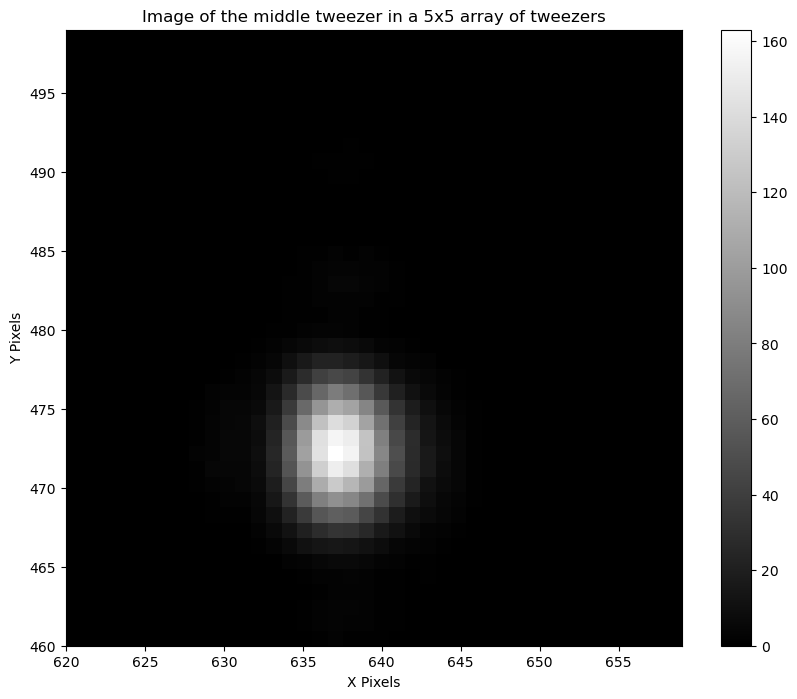

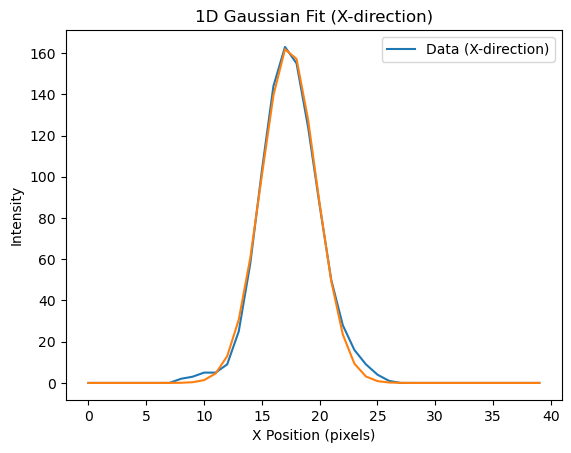

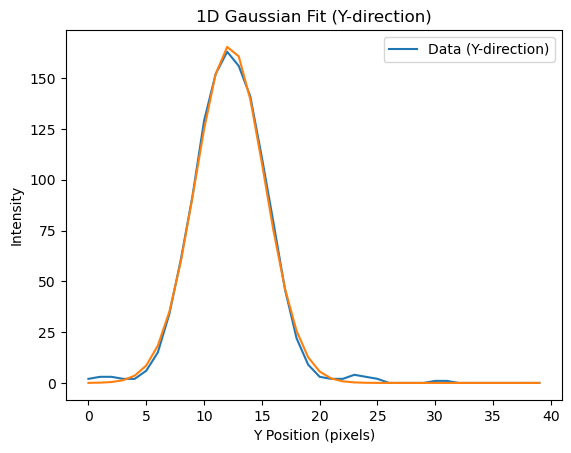

X-direction beam waist (1/e²): 2.15 μm
Y-direction beam waist (1/e²): 2.70 μm


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('phase_map_mod_2pi.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Extract row and column intensity profiles for fitting
# Use the row with the maximum intensity for x-direction fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

# Use the column with the maximum intensity for y-direction fitting
column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)
A_y, y0_y, sigma_y_fit = popt_y

# Incorporate magnification in the conversion from pixels to mm
pixel_to_mm = 1.85 * (24.5 / 100)  # Adjust scaling factor with magnification
sigma_x_fit_mm = sigma_x_fit * pixel_to_mm
sigma_y_fit_mm = sigma_y_fit * pixel_to_mm

# Plot the 1D Gaussian fit for the x-direction
plt.figure()
plt.plot(x_cropped_row, max_intensity_row_cropped, label='Data (X-direction)')
#plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit_mm:.2f} μm')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x))
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()
plt.show()

# Plot the 1D Gaussian fit for the y-direction
plt.figure()
plt.plot(y_cropped_col, max_intensity_column_cropped, label='Data (Y-direction)')
#plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit_mm:.2f} μm')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y))

plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.show()

# Print the results
print(f"X-direction beam waist (1/e²): {sigma_x_fit_mm:.2f} μm")
print(f"Y-direction beam waist (1/e²): {sigma_y_fit_mm:.2f} μm")


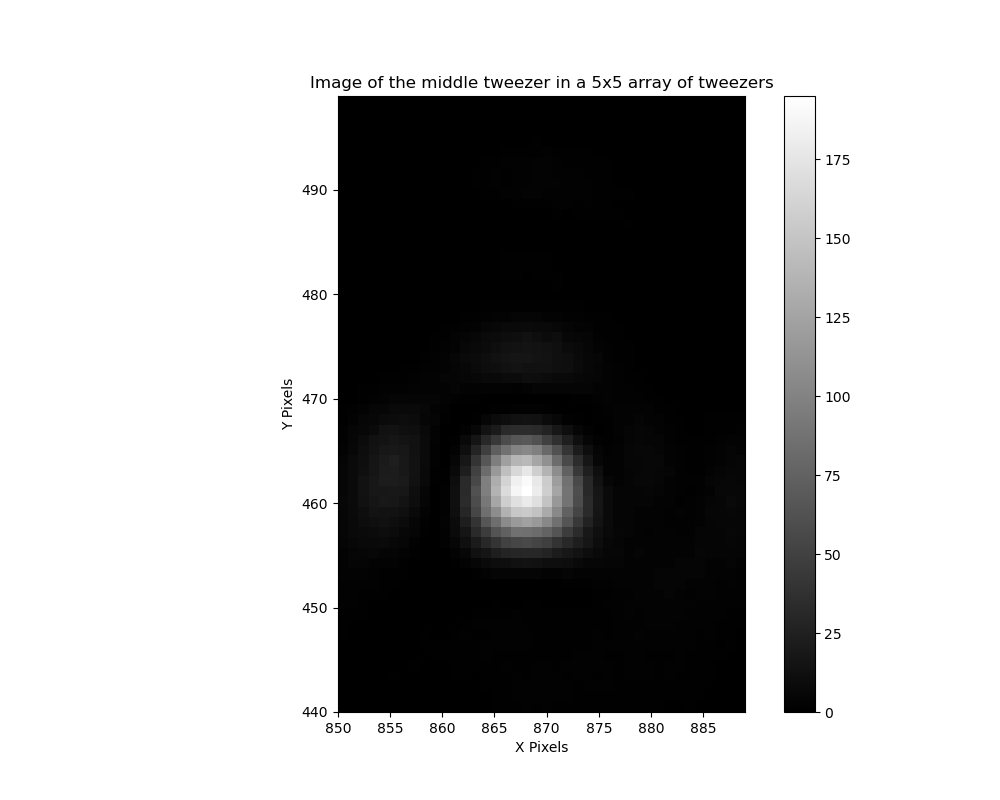

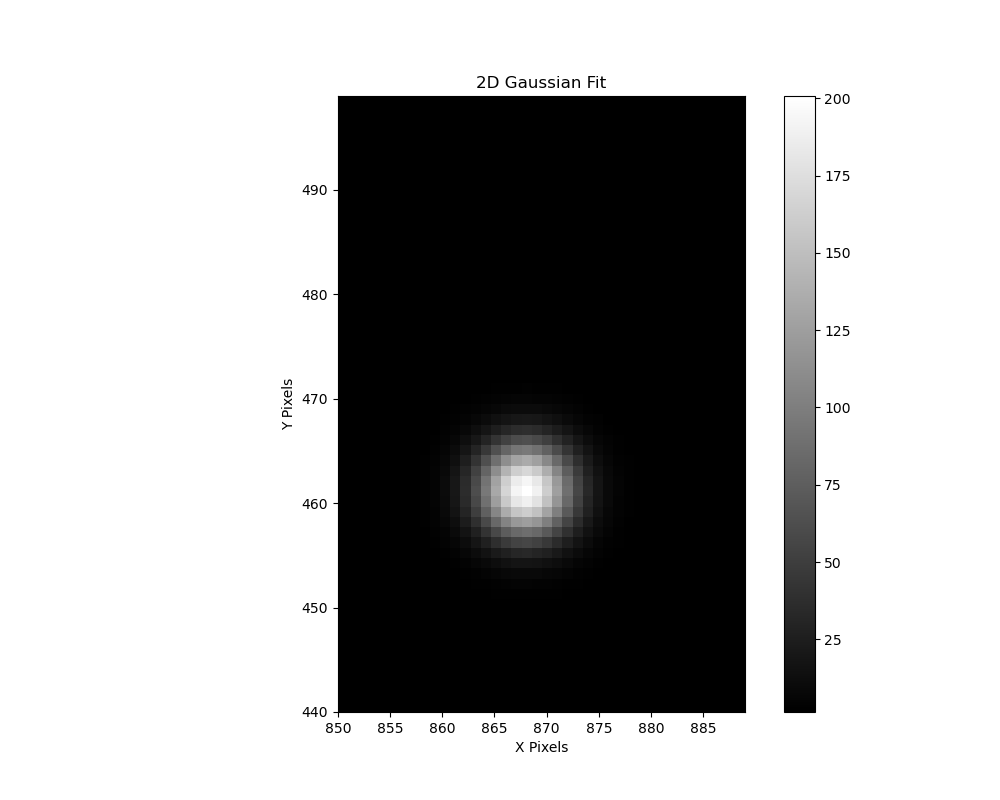

1D Gaussian Fit (X-direction) SSR: 2187.40
1D Gaussian Fit (Y-direction) SSR: 1390.32
2D Gaussian Fit SSR: 28543.65
2D Gaussian Fit Parameters:
A = 199.46, x0 = 867.90, y0 = 461.12,
sigma_x = 6.34, sigma_y = 6.37, B = 1.50
Max intensity: 858.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('4_spots_square.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 440, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 850, 890  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Define the 2D Gaussian function
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, B):
    x, y = coords
    return A * np.exp(-2 * ((x - x0)**2 / sigma_x**2 + (y - y0)**2 / sigma_y**2)) + B

# Extract row and column intensity profiles for fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit the 1D Gaussian for the x-direction
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)

# Fit the 1D Gaussian for the y-direction
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)

# Fit the 2D Gaussian to the cropped image
initial_guess_2d = [
    np.max(cropped_image),  # Amplitude
    x_cropped.mean(),  # x0
    y_cropped.mean(),  # y0
    10,  # sigma_x
    10,  # sigma_y
    np.min(cropped_image)  # Background
]

popt_2d, _ = curve_fit(
    gaussian_2d,
    (x_mesh.ravel(), y_mesh.ravel()),
    cropped_image.ravel(),
    p0=initial_guess_2d
)

# Extract 2D Gaussian parameters
A_2d, x0_2d, y0_2d, sigma_x_2d, sigma_y_2d, B_2d = popt_2d

# Reconstruct 2D Gaussian fit
fitted_2d = gaussian_2d((x_mesh, y_mesh), *popt_2d).reshape(cropped_image.shape)

# Calculate SSR for 1D fits
residuals_x = max_intensity_row_cropped - gaussian_1d(x_cropped_row, *popt_x)
ssr_1d_x = np.sum(residuals_x**2)

residuals_y = max_intensity_column_cropped - gaussian_1d(y_cropped_col, *popt_y)
ssr_1d_y = np.sum(residuals_y**2)

# Calculate SSR for 2D fit
residuals_2d = cropped_image - fitted_2d
ssr_2d = np.sum(residuals_2d**2)

# Plot the 2D Gaussian fit
plt.figure(figsize=(10, 8))
plt.imshow(fitted_2d, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('2D Gaussian Fit')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()


cropped_image_without = cropped_image
fitted_2d_without = fitted_2d
residuals_2d_without = residuals_2d
# Print the results
print(f"1D Gaussian Fit (X-direction) SSR: {ssr_1d_x:.2f}")
print(f"1D Gaussian Fit (Y-direction) SSR: {ssr_1d_y:.2f}")
print(f"2D Gaussian Fit SSR: {ssr_2d:.2f}")

# Print the fitted parameters
print(f"2D Gaussian Fit Parameters:\n"
      f"A = {A_2d:.2f}, x0 = {x0_2d:.2f}, y0 = {y0_2d:.2f},\n"
      f"sigma_x = {sigma_x_2d:.2f}, sigma_y = {sigma_y_2d:.2f}, B = {B_2d:.2f}")

print(f"Max intensity: {np.argmax(fitted_2d):.2f}")


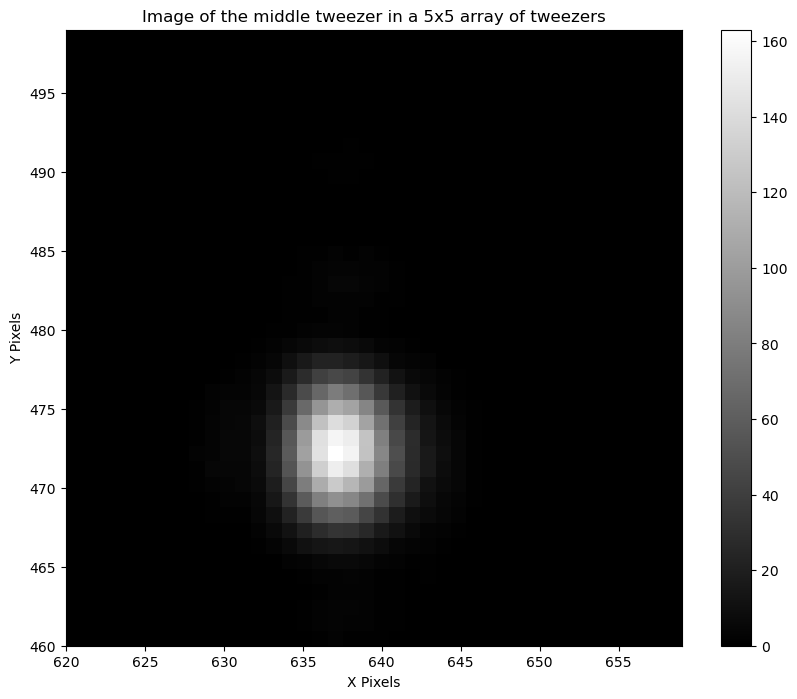

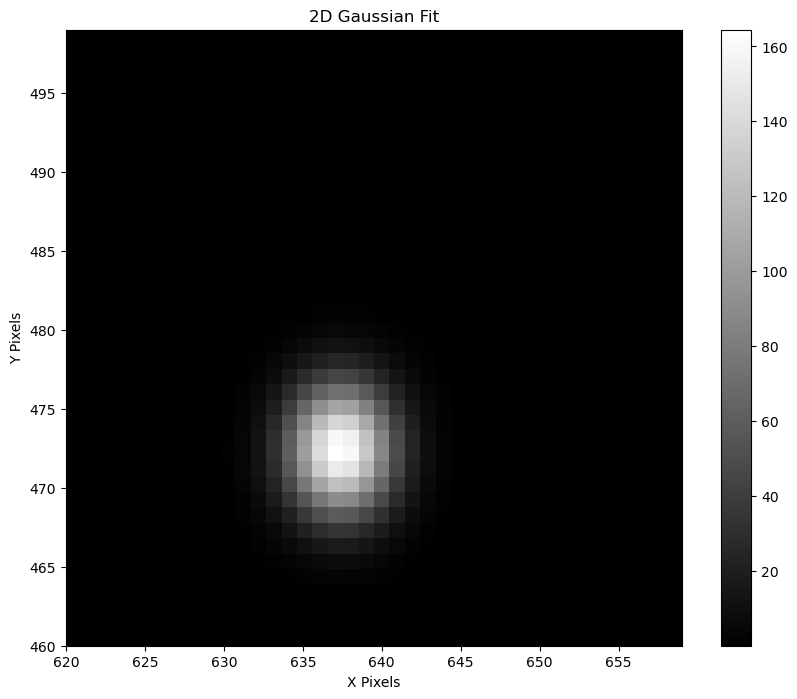

1D Gaussian Fit (X-direction) SSR: 235.01
1D Gaussian Fit (Y-direction) SSR: 177.35
2D Gaussian Fit SSR: 1911.69
2D Gaussian Fit Parameters:
A = 166.50, x0 = 637.33, y0 = 472.24,
sigma_x = 4.71, sigma_y = -5.89, B = 0.10


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('phase_map_mod_2pi.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Define the 2D Gaussian function
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, B):
    x, y = coords
    return A * np.exp(-2 * ((x - x0)**2 / sigma_x**2 + (y - y0)**2 / sigma_y**2)) + B

# Extract row and column intensity profiles for fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit the 1D Gaussian for the x-direction
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)

# Fit the 1D Gaussian for the y-direction
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)

# Fit the 2D Gaussian to the cropped image
initial_guess_2d = [
    np.max(cropped_image),  # Amplitude
    x_cropped.mean(),  # x0
    y_cropped.mean(),  # y0
    10,  # sigma_x
    10,  # sigma_y
    np.min(cropped_image)  # Background
]

popt_2d, _ = curve_fit(
    gaussian_2d,
    (x_mesh.ravel(), y_mesh.ravel()),
    cropped_image.ravel(),
    p0=initial_guess_2d
)

# Extract 2D Gaussian parameters
A_2d, x0_2d, y0_2d, sigma_x_2d, sigma_y_2d, B_2d = popt_2d

# Reconstruct 2D Gaussian fit
fitted_2d = gaussian_2d((x_mesh, y_mesh), *popt_2d).reshape(cropped_image.shape)

# Calculate SSR for 1D fits
residuals_x = max_intensity_row_cropped - gaussian_1d(x_cropped_row, *popt_x)
ssr_1d_x = np.sum(residuals_x**2)

residuals_y = max_intensity_column_cropped - gaussian_1d(y_cropped_col, *popt_y)
ssr_1d_y = np.sum(residuals_y**2)

# Calculate SSR for 2D fit
residuals_2d = cropped_image - fitted_2d
ssr_2d = np.sum(residuals_2d**2)

# Plot the 2D Gaussian fit
plt.figure(figsize=(10, 8))
plt.imshow(fitted_2d, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('2D Gaussian Fit')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Variables for the "with correction" case
cropped_image_with = cropped_image
fitted_2d_with = fitted_2d
residuals_2d_with = residuals_2d

# Print the results
print(f"1D Gaussian Fit (X-direction) SSR: {ssr_1d_x:.2f}")
print(f"1D Gaussian Fit (Y-direction) SSR: {ssr_1d_y:.2f}")
print(f"2D Gaussian Fit SSR: {ssr_2d:.2f}")

# Print the fitted parameters
print(f"2D Gaussian Fit Parameters:\n"
      f"A = {A_2d:.2f}, x0 = {x0_2d:.2f}, y0 = {y0_2d:.2f},\n"
      f"sigma_x = {sigma_x_2d:.2f}, sigma_y = {sigma_y_2d:.2f}, B = {B_2d:.2f}")


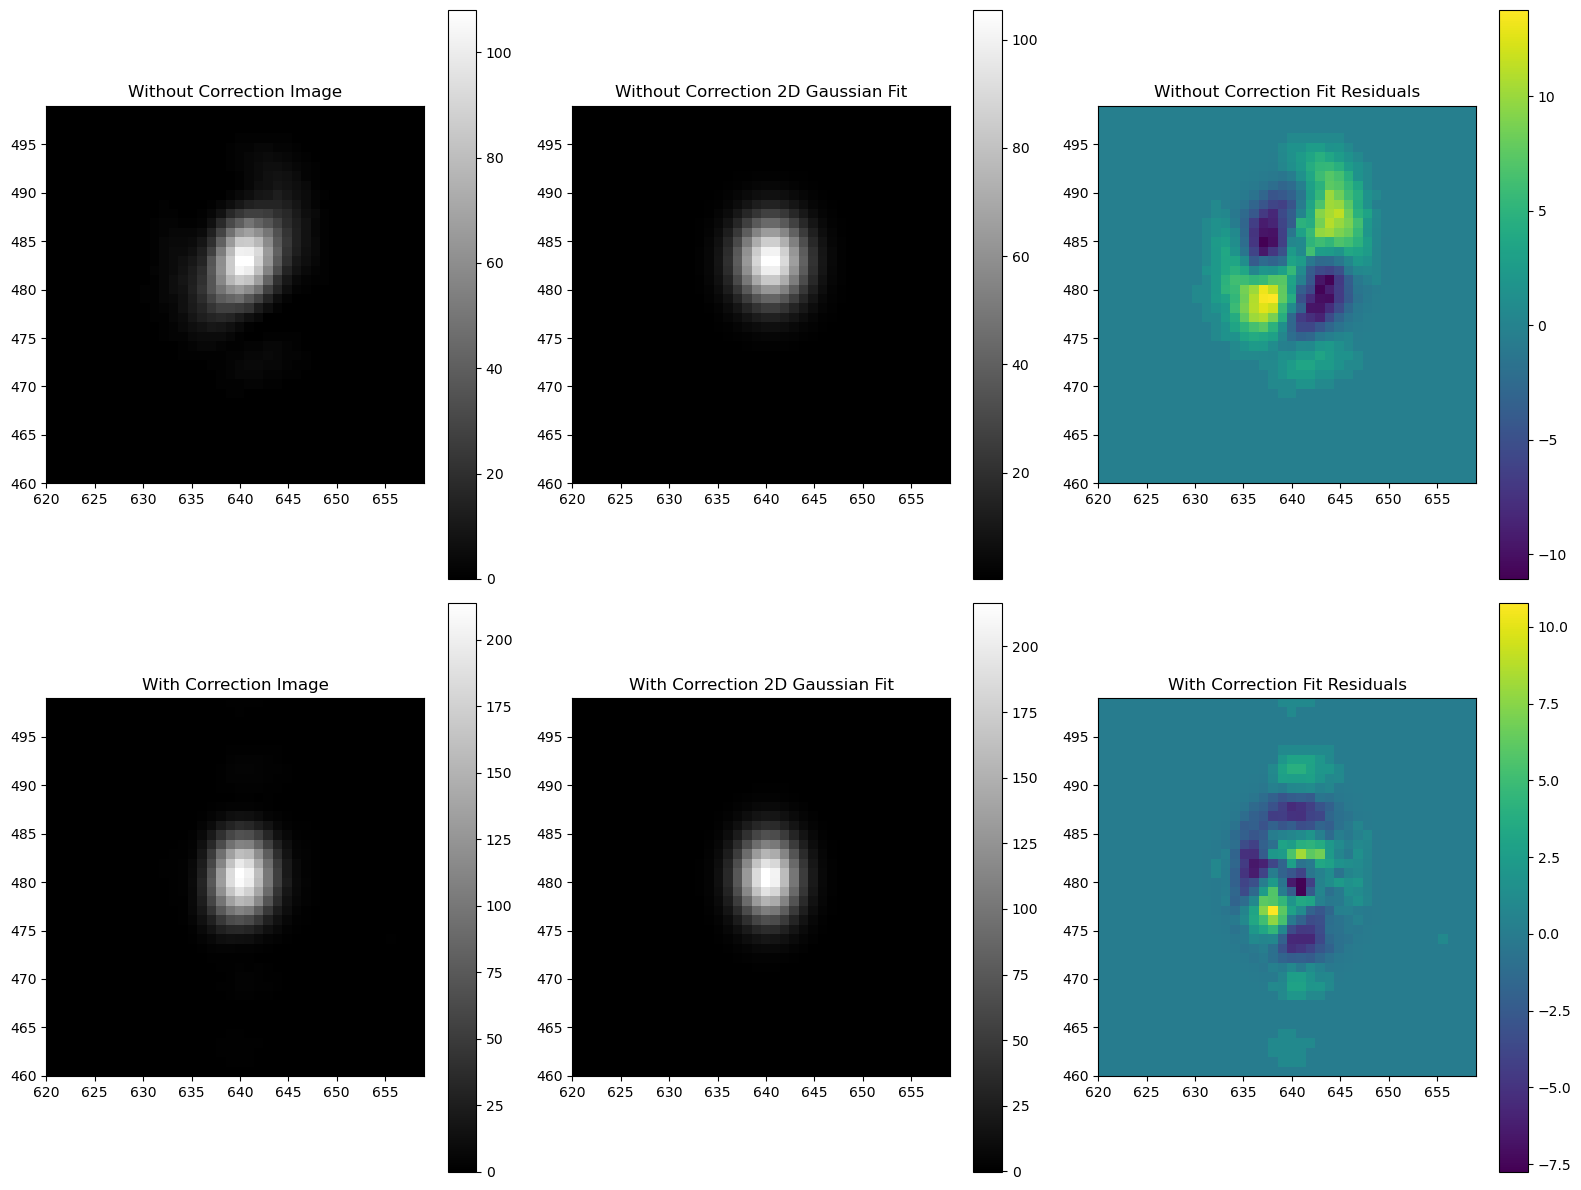

NameError: name 'max_intensity_row_cropped_corrected' is not defined

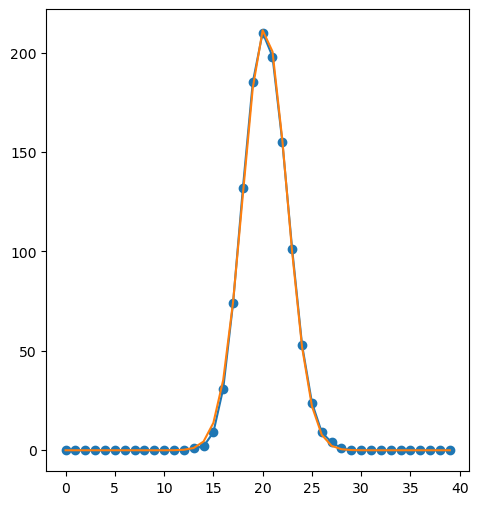

In [96]:
# Use descriptive variable names for clarity
# Variables for the "without correction" case


# Plot the cropped images and their Gaussian fits
plt.figure(figsize=(16, 12))

# Without correction
plt.subplot(2, 3, 1)
plt.imshow(cropped_image_without, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Without Correction Image')

plt.subplot(2, 3, 2)
plt.imshow(fitted_2d_without, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Without Correction 2D Gaussian Fit')

plt.subplot(2, 3, 3)
plt.imshow(residuals_2d_without, cmap='viridis', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Without Correction Fit Residuals')

# With correction
plt.subplot(2, 3, 4)
plt.imshow(cropped_image_with, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('With Correction Image')

plt.subplot(2, 3, 5)
plt.imshow(fitted_2d_with, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('With Correction 2D Gaussian Fit')

plt.subplot(2, 3, 6)
plt.imshow(residuals_2d_with, cmap='viridis', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('With Correction Fit Residuals')

plt.tight_layout()
plt.show()

# Plot intensity profiles for x- and y-directions
plt.figure(figsize=(12, 6))

# X-direction
plt.subplot(1, 2, 1)
plt.plot(x_cropped_row, max_intensity_row_cropped, 'o-', label='Without Correction')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x), '-', label='Without Correction Fit')
plt.plot(x_cropped_row, max_intensity_row_cropped_corrected, 'x-', label='With Correction')
plt.plot(x_cropped_row, gaussian_1d(x_cropped_row, *popt_x_corrected), '--', label='With Correction Fit')
plt.title('X-Direction Intensity Profiles')
plt.xlabel('X Pixels')
plt.ylabel('Intensity')
plt.legend()

# Y-direction
plt.subplot(1, 2, 2)
plt.plot(y_cropped_col, max_intensity_column_cropped, 'o-', label='Without Correction')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y), '-', label='Without Correction Fit')
plt.plot(y_cropped_col, max_intensity_column_cropped_corrected, 'x-', label='With Correction')
plt.plot(y_cropped_col, gaussian_1d(y_cropped_col, *popt_y_corrected), '--', label='With Correction Fit')
plt.title('Y-Direction Intensity Profiles')
plt.xlabel('Y Pixels')
plt.ylabel('Intensity')
plt.legend()

plt.tight_layout()
plt.show()


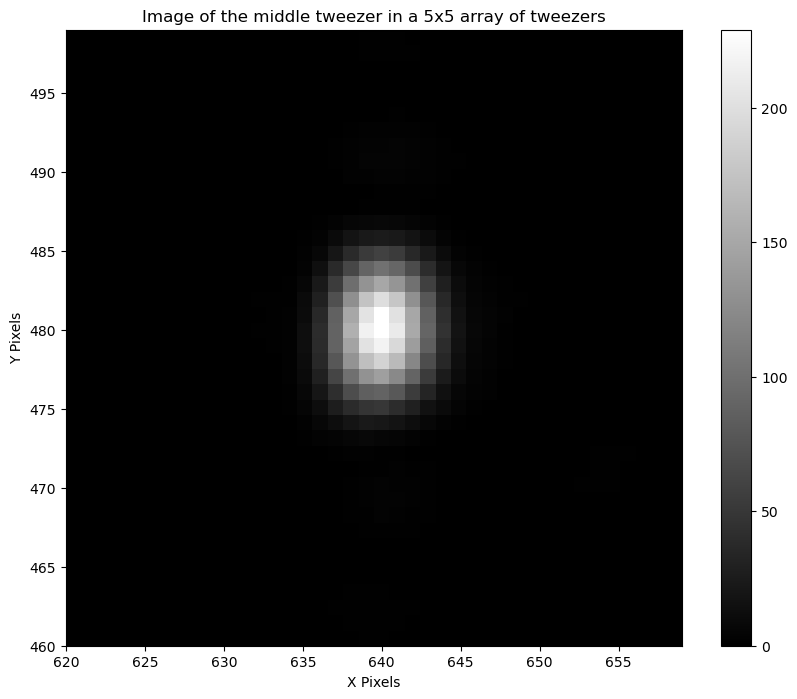

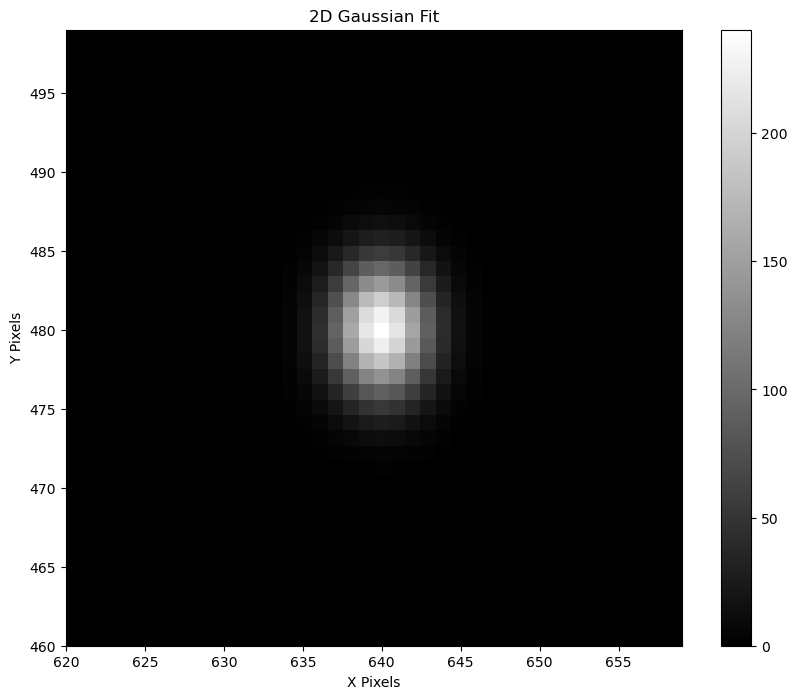

1D Gaussian Fit (X-direction) SSR: 120.57
1D Gaussian Fit (Y-direction) SSR: 515.58
2D Gaussian Fit SSR: 2770.51
2D Gaussian Fit Parameters:
A = 240.49, x0 = 639.98, y0 = 480.08,
sigma_x = 4.33, sigma_y = 5.83, B = -0.02


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('21_01_spots_w_phase_map_fit_mod.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Image of the middle tweezer in a 5x5 array of tweezers')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Define the 2D Gaussian function
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, B):
    x, y = coords
    return A * np.exp(-2 * ((x - x0)**2 / sigma_x**2 + (y - y0)**2 / sigma_y**2)) + B

# Extract row and column intensity profiles for fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit the 1D Gaussian for the x-direction
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)

# Fit the 1D Gaussian for the y-direction
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)

# Fit the 2D Gaussian to the cropped image
initial_guess_2d = [
    np.max(cropped_image),  # Amplitude
    x_cropped.mean(),  # x0
    y_cropped.mean(),  # y0
    10,  # sigma_x
    10,  # sigma_y
    np.min(cropped_image)  # Background
]

popt_2d, _ = curve_fit(
    gaussian_2d,
    (x_mesh.ravel(), y_mesh.ravel()),
    cropped_image.ravel(),
    p0=initial_guess_2d
)

# Extract 2D Gaussian parameters
A_2d, x0_2d, y0_2d, sigma_x_2d, sigma_y_2d, B_2d = popt_2d

# Reconstruct 2D Gaussian fit
fitted_2d = gaussian_2d((x_mesh, y_mesh), *popt_2d).reshape(cropped_image.shape)

# Calculate SSR for 1D fits
residuals_x = max_intensity_row_cropped - gaussian_1d(x_cropped_row, *popt_x)
ssr_1d_x = np.sum(residuals_x**2)

residuals_y = max_intensity_column_cropped - gaussian_1d(y_cropped_col, *popt_y)
ssr_1d_y = np.sum(residuals_y**2)

# Calculate SSR for 2D fit
residuals_2d = cropped_image - fitted_2d
ssr_2d = np.sum(residuals_2d**2)

# Plot the 2D Gaussian fit
plt.figure(figsize=(10, 8))
plt.imshow(fitted_2d, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('2D Gaussian Fit')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Print the results
print(f"1D Gaussian Fit (X-direction) SSR: {ssr_1d_x:.2f}")
print(f"1D Gaussian Fit (Y-direction) SSR: {ssr_1d_y:.2f}")
print(f"2D Gaussian Fit SSR: {ssr_2d:.2f}")

# Print the fitted parameters
print(f"2D Gaussian Fit Parameters:\n"
      f"A = {A_2d:.2f}, x0 = {x0_2d:.2f}, y0 = {y0_2d:.2f},\n"
      f"sigma_x = {sigma_x_2d:.2f}, sigma_y = {sigma_y_2d:.2f}, B = {B_2d:.2f}")


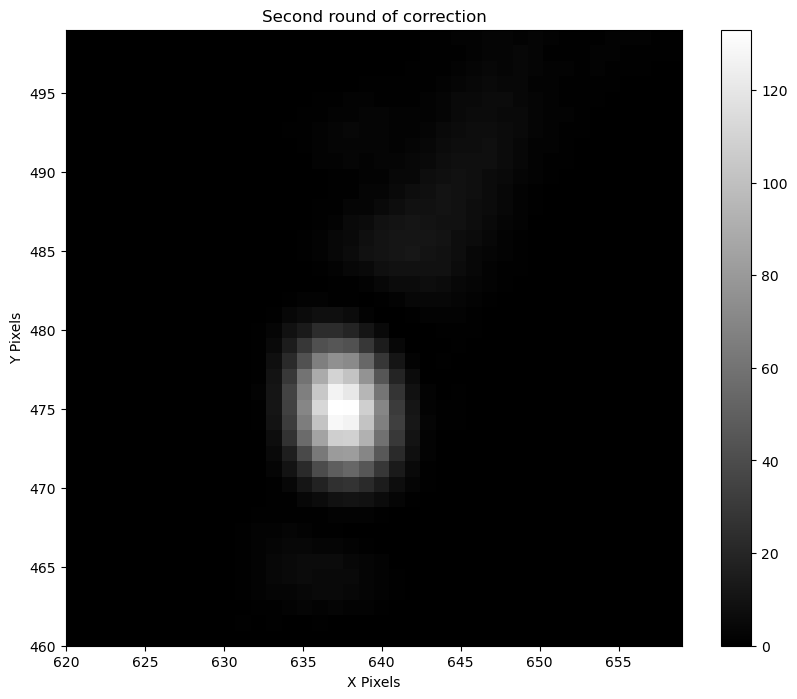

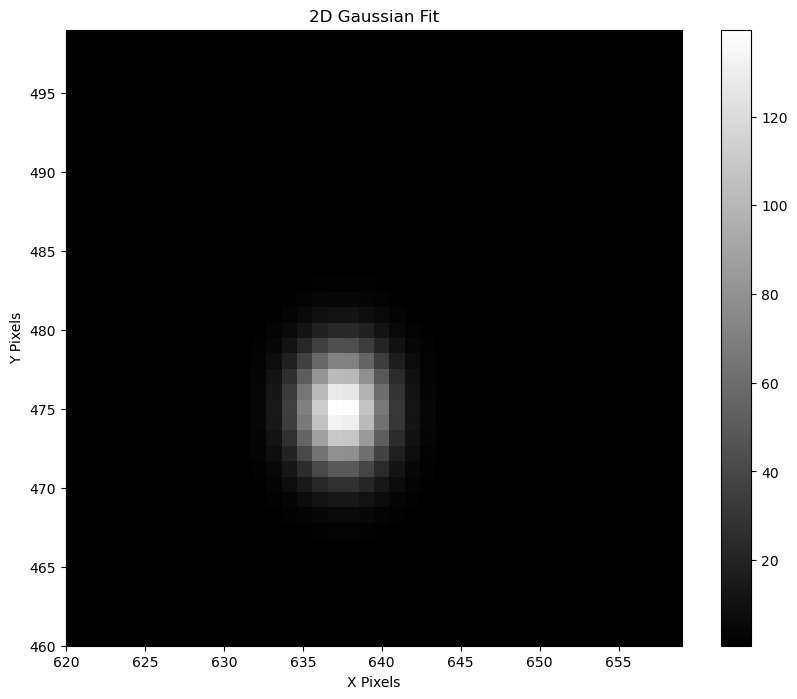

1D Gaussian Fit (X-direction) SSR: 78.83
1D Gaussian Fit (Y-direction) SSR: 309.74
2D Gaussian Fit SSR: 7857.53
2D Gaussian Fit Parameters:
A = 142.34, x0 = 637.45, y0 = 474.88,
sigma_x = 4.09, sigma_y = 5.39, B = 0.73


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('21_01_both_corrections.tiff')

# Manually specify the region of interest (adjust these values based on the image structure)
roi_y_start, roi_y_end = 460, 500  # Y-axis range (rows) for cropping
roi_x_start, roi_x_end = 620, 660  # X-axis range (columns) for cropping

# Crop the image to focus on the region containing Gaussian beams
cropped_image = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]

# Generate x and y coordinates for the cropped image
x_cropped = np.arange(roi_x_start, roi_x_end)
y_cropped = np.arange(roi_y_start, roi_y_end)
x_mesh, y_mesh = np.meshgrid(x_cropped, y_cropped)

# Plot the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('Second round of correction')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Define the 1D Gaussian function
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2 * (x - x0)**2 / (sigma**2))

# Define the 2D Gaussian function
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, B):
    x, y = coords
    return A * np.exp(-2 * ((x - x0)**2 / sigma_x**2 + (y - y0)**2 / sigma_y**2)) + B

# Extract row and column intensity profiles for fitting
row_with_max_intensity = np.argmax(np.sum(cropped_image, axis=1))
max_intensity_row_cropped = cropped_image[row_with_max_intensity, :]
x_cropped_row = np.arange(max_intensity_row_cropped.size)

column_with_max_intensity = np.argmax(np.sum(cropped_image, axis=0))
max_intensity_column_cropped = cropped_image[:, column_with_max_intensity]
y_cropped_col = np.arange(max_intensity_column_cropped.size)

# Fit the 1D Gaussian for the x-direction
popt_x, _ = curve_fit(
    gaussian_1d,
    x_cropped_row,
    max_intensity_row_cropped,
    p0=[np.max(max_intensity_row_cropped), np.mean(x_cropped_row), 10]
)

# Fit the 1D Gaussian for the y-direction
popt_y, _ = curve_fit(
    gaussian_1d,
    y_cropped_col,
    max_intensity_column_cropped,
    p0=[np.max(max_intensity_column_cropped), np.mean(y_cropped_col), 10]
)

# Fit the 2D Gaussian to the cropped image
initial_guess_2d = [
    np.max(cropped_image),  # Amplitude
    x_cropped.mean(),  # x0
    y_cropped.mean(),  # y0
    10,  # sigma_x
    10,  # sigma_y
    np.min(cropped_image)  # Background
]

popt_2d, _ = curve_fit(
    gaussian_2d,
    (x_mesh.ravel(), y_mesh.ravel()),
    cropped_image.ravel(),
    p0=initial_guess_2d
)

# Extract 2D Gaussian parameters
A_2d, x0_2d, y0_2d, sigma_x_2d, sigma_y_2d, B_2d = popt_2d

# Reconstruct 2D Gaussian fit
fitted_2d = gaussian_2d((x_mesh, y_mesh), *popt_2d).reshape(cropped_image.shape)

# Calculate SSR for 1D fits
residuals_x = max_intensity_row_cropped - gaussian_1d(x_cropped_row, *popt_x)
ssr_1d_x = np.sum(residuals_x**2)

residuals_y = max_intensity_column_cropped - gaussian_1d(y_cropped_col, *popt_y)
ssr_1d_y = np.sum(residuals_y**2)

# Calculate SSR for 2D fit
residuals_2d = cropped_image - fitted_2d
ssr_2d = np.sum(residuals_2d**2)

# Plot the 2D Gaussian fit
plt.figure(figsize=(10, 8))
plt.imshow(fitted_2d, cmap='gray', origin='lower', extent=(x_cropped[0], x_cropped[-1], y_cropped[0], y_cropped[-1]))
plt.colorbar()
plt.title('2D Gaussian Fit')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

# Print the results
print(f"1D Gaussian Fit (X-direction) SSR: {ssr_1d_x:.2f}")
print(f"1D Gaussian Fit (Y-direction) SSR: {ssr_1d_y:.2f}")
print(f"2D Gaussian Fit SSR: {ssr_2d:.2f}")

# Print the fitted parameters
print(f"2D Gaussian Fit Parameters:\n"
      f"A = {A_2d:.2f}, x0 = {x0_2d:.2f}, y0 = {y0_2d:.2f},\n"
      f"sigma_x = {sigma_x_2d:.2f}, sigma_y = {sigma_y_2d:.2f}, B = {B_2d:.2f}")


Image dimensions: 640 pixels (x-direction), 480 pixels (y-direction)
X-direction (row) width (1/e²): 1.55 mm
Y-direction (column) width (1/e²): 1.50 mm
Column with highest intensity for x-direction: 313
Row with highest intensity for y-direction: 197


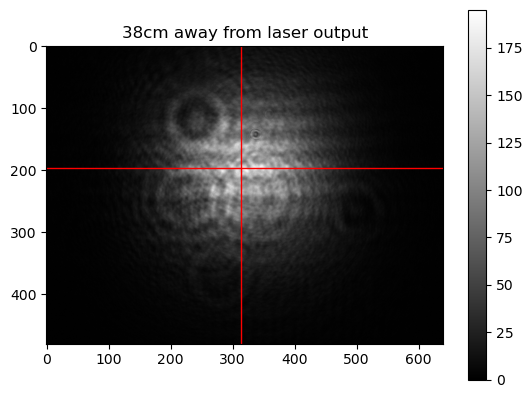

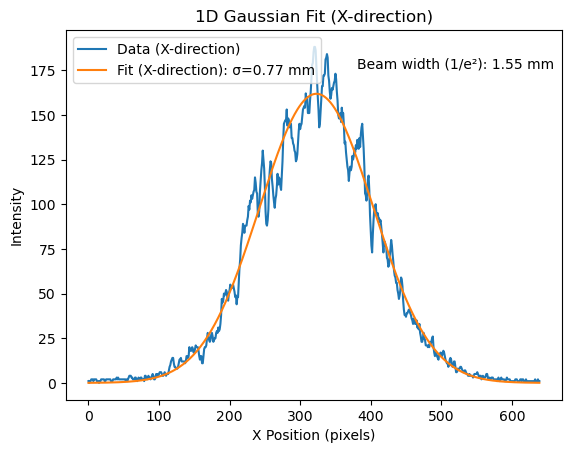

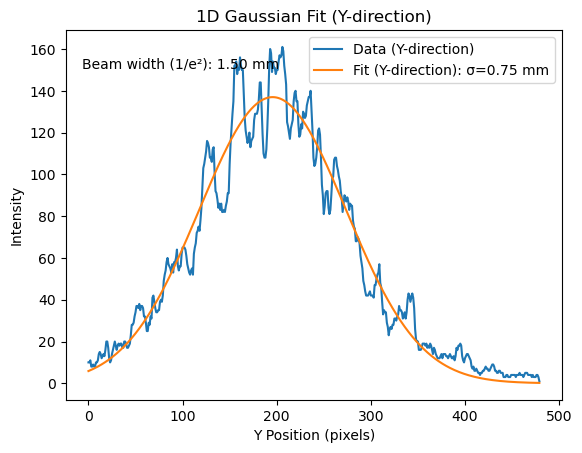

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Load your .tiff image
image = io.imread('beam_size_slm.tiff')

# Get the dimensions of the image
image_height, image_width = image.shape  # height is the number of rows, width is the number of columns

# Print the image dimensions
print(f"Image dimensions: {image_width} pixels (x-direction), {image_height} pixels (y-direction)")

# Define the 1D Gaussian function for fitting
def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-2*(x - x0)**2 / (sigma**2))

# Sum the intensities along each row to find the row with the highest intensity (x-direction)
intensity_sums_x = np.sum(image, axis=1)  # Sum intensities along each row (across columns)
max_row_index = np.argmax(intensity_sums_x)  # Find the row index with the highest intensity sum
max_intensity_row = image[max_row_index, :]  # Get the row with the highest intensity for x fit

# Sum the intensities along each column to find the column with the highest intensity (y-direction)
intensity_sums_y = np.sum(image, axis=0)  # Sum intensities along each column (across rows)
max_col_index = np.argmax(intensity_sums_y)  # Find the column index with the highest intensity sum
max_intensity_column = image[:, max_col_index]  # Get the column with the highest intensity for y fit

# Create x and y values corresponding to the row and column (x-coordinates and y-coordinates)
x = np.arange(image.shape[1])  # x-coordinates (width of the image, columns)
y = np.arange(image.shape[0])  # y-coordinates (height of the image, rows)

# Fit a 1D Gaussian to the row with the highest intensity (x-direction)
popt_x, _ = curve_fit(gaussian_1d, x, max_intensity_row, p0=[np.max(max_intensity_row), x[image.shape[1] // 2], 1])
A_x, x0_x, sigma_x_fit = popt_x

# Fit a 1D Gaussian to the column with the highest intensity (y-direction)
popt_y, _ = curve_fit(gaussian_1d, y, max_intensity_column, p0=[np.max(max_intensity_column), y[image.shape[0] // 2], 1])
A_y, y0_y, sigma_y_fit = popt_y

sigma_x_fit = sigma_x_fit*4.8/1000 #in mm instead of pixels
sigma_y_fit = sigma_y_fit*4.8/1000 #in mm instead of pixels

# Plot the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('38cm away from laser output')

# Add red lines at the row and column used for fitting
plt.axhline(y=max_row_index, color='red', linewidth=1, label=f'Row {max_row_index} used for x fit')
plt.axvline(x=max_col_index, color='red', linewidth=1, label=f'Column {max_col_index} used for y fit')


beam_width_x = 2*sigma_x_fit
beam_width_y = 2*sigma_y_fit


# Plot the original data and the 1D Gaussian fit for the x-direction (row)
plt.figure()
plt.plot(x, max_intensity_row, label='Data (X-direction)')
plt.plot(x, gaussian_1d(x, *popt_x), label=f'Fit (X-direction): σ={sigma_x_fit:.2f} mm')
plt.xlabel('X Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (X-direction)')
plt.legend()

# Move figtext to avoid overlapping with the plot, place it above the legend
plt.figtext(0.58, 0.8, f"Beam width (1/e²): {beam_width_x:.2f} mm", fontsize=10)

# Plot the original data and the 1D Gaussian fit for the y-direction (column)
plt.figure()
plt.plot(y, max_intensity_column, label='Data (Y-direction)')
plt.plot(y, gaussian_1d(y, *popt_y), label=f'Fit (Y-direction): σ={sigma_y_fit:.2f} mm')
plt.xlabel('Y Position (pixels)')
plt.ylabel('Intensity')
plt.title('1D Gaussian Fit (Y-direction)')
plt.legend()
plt.figtext(0.15, 0.8, f"Beam width (1/e²): {beam_width_y:.2f} mm", fontsize=10)

# Print the beam widths (1/e²) for both x and y directions
print(f"X-direction (row) width (1/e²): {beam_width_x:.2f} mm")
print(f"Y-direction (column) width (1/e²): {beam_width_y:.2f} mm")
print(f"Column with highest intensity for x-direction: {max_col_index}")  # Correctly print the column index for y
print(f"Row with highest intensity for y-direction: {max_row_index}")  # Correctly print the row index for x

plt.show()


In [4]:
0.75*(1000/150)

5.0